In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import json
import splitfolders

In [2]:
#splitfolders.ratio('XRAY_Collective_Data', output="data", seed=1337, ratio=(0.8, 0.2)) 

In [3]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

class CyclicLR(Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [5]:
def dumpHistory(name, hist):
    acc, val_acc, loss, val_loss = [],[],[],[]
    if(os.path.isfile('history/' + name + '.json')):
        acc, val_acc, loss, val_loss = loadHistory(name)
    acc += hist.history['accuracy']
    val_acc += hist.history['val_accuracy']

    loss += hist.history['loss']
    val_loss += hist.history['val_loss']

    hist_dict = {
        "acc": acc,
        "val_acc": val_acc,
        "loss": loss,
        "val_loss": val_loss
    }

    with open('history/' + name + '.json', 'w', encoding='utf-8') as f:
        json.dump(hist_dict, f, ensure_ascii=False, indent=4)
    #print('DUMPED\n')

In [4]:
def loadHistory(name):
    with open('history/' + name + '.json', "r") as read_file:
        hist_dict = json.load(read_file)

    acc = hist_dict['acc']
    val_acc = hist_dict['val_acc']
    loss = hist_dict['loss']
    val_loss = hist_dict['val_loss']
    return acc, val_acc, loss, val_loss

In [6]:
def distplayHistory(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [7]:
base_learning_rate = 5e-3
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
PATH = os.path.join('data_xray')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

min_LR = 1e-5
max_LR = 1e-3
step_size = 8
clr_method = "triangular"
clr = CyclicLR(mode = clr_method,base_lr=min_LR, max_lr=max_LR,step_size=step_size*BATCH_SIZE)

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE, 
                                                            label_mode = 'categorical')
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode = 'categorical')

Found 5216 files belonging to 2 classes.
Found 640 files belonging to 2 classes.


In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
preprocess_input = tf.keras.applications.xception.preprocess_input

XCEPTION

XCEPTION NO TRANSFER

In [17]:
preprocess_input_XNT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XNT = IMG_SIZE + (3,)
xception_model_XNT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XNT,
                                               include_top=False)
image_batch_XNT, label_batch_XNT = next(iter(train_dataset))
feature_batch_XNT = xception_model_XNT(image_batch_XNT)

global_average_layer_XNT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XNT = global_average_layer_XNT(feature_batch_XNT)

'''fc1_layer_XNT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_XNT = fc1_layer_XNT(feature_batch_average_XNT)'''

prediction_layer_XNT = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_XNT = prediction_layer_XNT(feature_batch_average_XNT)

inputs_XNT = tf.keras.Input(shape=(160, 160, 3))
x_XNT = preprocess_input_XNT(inputs_XNT)
x_XNT = xception_model_XNT(x_XNT)
x_XNT = global_average_layer_XNT(x_XNT)
'''x_XNT = tf.keras.layers.Dropout(0.2)(x_XNT)
x_XNT = fc1_layer_XNT(x_XNT)'''
x_XNT = tf.keras.layers.Dropout(0.2)(x_XNT)
outputs_XNT = prediction_layer_XNT(x_XNT)
model_XNT = tf.keras.Model(inputs_XNT, outputs_XNT)
model_XNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XNT = "training_models/XRAY_XNT.ckpt"
checkpoint_dir_XNT = os.path.dirname(checkpoint_path_XNT)
cp_callback_XNT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [18]:
total_epochs_XNT = 10
history_XNT = model_XNT.fit(train_dataset,
                         epochs=total_epochs_XNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XNT])
initial_epochs_XNT=total_epochs_XNT
dumpHistory('XNTceptionXRAY', history_XNT)

Epoch 1/10
82/82 [==============================] - 213s 3s/step - loss: 0.4594 - accuracy: 0.7926 - val_loss: 0.8070 - val_accuracy: 0.6426
Epoch 2/10
82/82 [==============================] - 206s 2s/step - loss: 0.2889 - accuracy: 0.8921 - val_loss: 0.7833 - val_accuracy: 0.6641
Epoch 3/10
82/82 [==============================] - 206s 2s/step - loss: 0.2085 - accuracy: 0.9388 - val_loss: 0.6242 - val_accuracy: 0.7402
Epoch 4/10
82/82 [==============================] - 206s 2s/step - loss: 0.1493 - accuracy: 0.9565 - val_loss: 0.4539 - val_accuracy: 0.8340
Epoch 5/10
82/82 [==============================] - 198s 2s/step - loss: 0.1213 - accuracy: 0.9647 - val_loss: 0.4351 - val_accuracy: 0.8477
Epoch 6/10
82/82 [==============================] - 194s 2s/step - loss: 0.0972 - accuracy: 0.9718 - val_loss: 0.4509 - val_accuracy: 0.8340
Epoch 7/10
82/82 [==============================] - 193s 2s/step - loss: 0.0754 - accuracy: 0.9791 - val_loss: 0.4357 - val_accuracy: 0.8359
Epoch 8/10
82

In [19]:
model_XNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XNT = 10
total_epochs_XNT =  initial_epochs_XNT + add_epochs_XNT

history_XNT = model_XNT.fit(train_dataset,
                         epochs=total_epochs_XNT,
                         initial_epoch=initial_epochs_XNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XNT, clr])
initial_epochs_XNT+=add_epochs_XNT
dumpHistory('XNTceptionXRAY', history_XNT)

Epoch 11/20
82/82 [==============================] - 212s 3s/step - loss: 0.0441 - accuracy: 0.9887 - val_loss: 0.5839 - val_accuracy: 0.8203
Epoch 12/20
82/82 [==============================] - 206s 2s/step - loss: 0.0440 - accuracy: 0.9870 - val_loss: 0.5819 - val_accuracy: 0.8164
Epoch 13/20
82/82 [==============================] - 206s 2s/step - loss: 0.0405 - accuracy: 0.9904 - val_loss: 0.6465 - val_accuracy: 0.8086
Epoch 14/20
82/82 [==============================] - 205s 2s/step - loss: 0.0413 - accuracy: 0.9898 - val_loss: 0.6084 - val_accuracy: 0.8125
Epoch 15/20
82/82 [==============================] - 203s 2s/step - loss: 0.0378 - accuracy: 0.9898 - val_loss: 0.6773 - val_accuracy: 0.7930
Epoch 16/20
82/82 [==============================] - 204s 2s/step - loss: 0.0389 - accuracy: 0.9902 - val_loss: 0.5798 - val_accuracy: 0.8223
Epoch 17/20
82/82 [==============================] - 205s 2s/step - loss: 0.0399 - accuracy: 0.9895 - val_loss: 0.6333 - val_accuracy: 0.8105
Epoch 

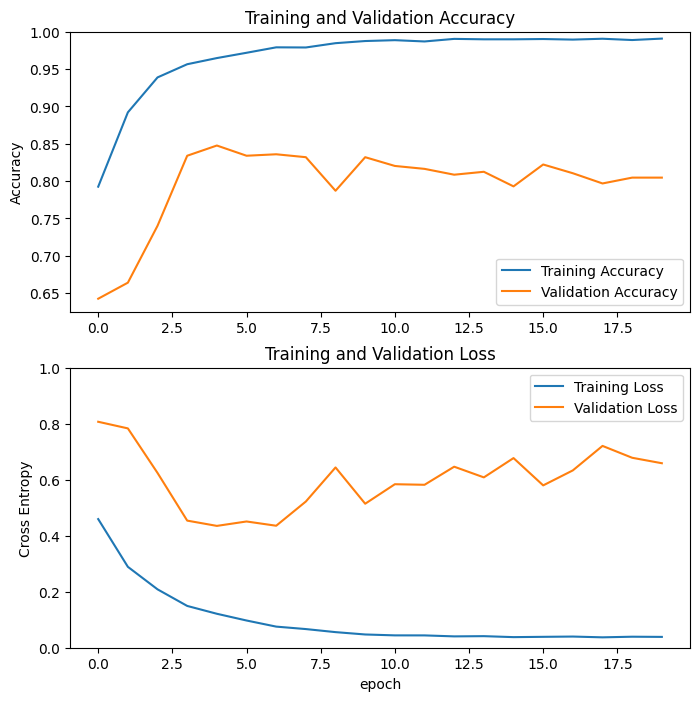

In [20]:
acc_XNT, val_acc_XNT, loss_XNT, val_loss_XNT = loadHistory('XNTceptionXRAY')
distplayHistory(acc_XNT, val_acc_XNT, loss_XNT, val_loss_XNT)

In [21]:
loss0, accuracy0 = model_XNT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss0))
print("Test accuracy: {:.4f}".format(accuracy0))

2/2 [==============================] - 3s 673ms/step - loss: 0.5969 - accuracy: 0.8125
Test loss: 0.5969
Test accuracy: 0.8125


XCEPTION FAST TRANSFER

In [31]:
preprocess_input_XFT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XFT = IMG_SIZE + (3,)
xception_model_XFT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XFT,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XFT.trainable = False
image_batch_XFT, label_batch_XFT = next(iter(train_dataset))
feature_batch_XFT = xception_model_XFT(image_batch_XFT)
global_average_layer_XFT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XFT = global_average_layer_XFT(feature_batch_XFT)

'''fc1_layer_XFT = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_XFT = fc1_layer_XFT(feature_batch_average_XFT)'''

prediction_layer_XFT = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_XFT = prediction_layer_XFT(feature_batch_average_XFT)

inputs_XFT = tf.keras.Input(shape=(160, 160, 3))
x_XFT = preprocess_input_XFT(inputs_XFT)
x_XFT = xception_model_XFT(x_XFT)
x_XFT = global_average_layer_XFT(x_XFT)
x_XFT = tf.keras.layers.Dropout(0.2)(x_XFT)
outputs_XFT = prediction_layer_XFT(x_XFT)
model_XFT = tf.keras.Model(inputs_XFT, outputs_XFT)
model_XFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XFT = "training_models/XRAY_XFT.ckpt"
checkpoint_dir_XFT = os.path.dirname(checkpoint_path_XFT)
cp_callback_XFT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XFT,
                                                 save_weights_only=True,
                                                 verbose=0)

In [32]:
total_epochs_XFT = 5
history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT])
initial_epochs_XFT=total_epochs_XFT
dumpHistory('XFTceptionXRAY', history_XFT)

Epoch 1/5
82/82 [==============================] - 70s 794ms/step - loss: 0.3658 - accuracy: 0.8328 - val_loss: 0.5799 - val_accuracy: 0.7383
Epoch 2/5
82/82 [==============================] - 65s 775ms/step - loss: 0.2456 - accuracy: 0.9036 - val_loss: 0.6437 - val_accuracy: 0.7207
Epoch 3/5
82/82 [==============================] - 65s 777ms/step - loss: 0.2183 - accuracy: 0.9124 - val_loss: 0.5332 - val_accuracy: 0.7832
Epoch 4/5
82/82 [==============================] - 66s 778ms/step - loss: 0.2073 - accuracy: 0.9176 - val_loss: 0.5436 - val_accuracy: 0.7871
Epoch 5/5
82/82 [==============================] - 66s 776ms/step - loss: 0.1953 - accuracy: 0.9227 - val_loss: 0.5508 - val_accuracy: 0.7695


In [33]:
xception_model_XFT.trainable = True
fine_tune_at_XFT = 120
for layer_XFT in xception_model_XFT.layers[:fine_tune_at_XFT]:
  layer_XFT.trainable = False
model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XFT = 1
total_epochs_XFT =  initial_epochs_XFT + fine_tune_epochs_XFT

history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=initial_epochs_XFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT])
dumpHistory('XFTceptionXRAY', history_XFT)
initial_epochs_XFT += fine_tune_epochs_XFT
for i in range (4):
  xception_model_XFT.trainable = True
  fine_tune_at_XFT -= 30
  for layer_XFT in xception_model_XFT.layers[:fine_tune_at_XFT]:
    layer_XFT.trainable = False
  model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XFT = 1
  total_epochs_XFT =  initial_epochs_XFT + fine_tune_epochs_XFT


  history_XFT = model_XFT.fit(train_dataset,
                          epochs=total_epochs_XFT,
                          initial_epoch=initial_epochs_XFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_XFT])
  dumpHistory('XFTceptionXRAY', history_XFT)
  initial_epochs_XFT+=fine_tune_epochs_XFT


Epoch 6/6
82/82 [==============================] - 80s 913ms/step - loss: 0.4620 - accuracy: 0.8418 - val_loss: 1.0142 - val_accuracy: 0.6289
Epoch 7/7
82/82 [==============================] - 103s 1s/step - loss: 0.4965 - accuracy: 0.7987 - val_loss: 0.7742 - val_accuracy: 0.6445
Epoch 8/8
82/82 [==============================] - 126s 1s/step - loss: 0.5124 - accuracy: 0.7822 - val_loss: 0.5802 - val_accuracy: 0.6914
Epoch 9/9
82/82 [==============================] - 152s 2s/step - loss: 0.5239 - accuracy: 0.7724 - val_loss: 0.5667 - val_accuracy: 0.6914
Epoch 10/10
82/82 [==============================] - 212s 3s/step - loss: 0.4890 - accuracy: 0.7868 - val_loss: 0.5309 - val_accuracy: 0.7188


In [34]:
model_XFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XFT = 10
total_epochs_XFT =  initial_epochs_XFT + add_epochs_XFT

history_XFT = model_XFT.fit(train_dataset,
                         epochs=total_epochs_XFT,
                         initial_epoch=initial_epochs_XFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XFT, clr])
initial_epochs_XFT+=add_epochs_XFT
dumpHistory('XFTceptionXRAY', history_XFT)

Epoch 11/20
82/82 [==============================] - 211s 2s/step - loss: 0.4476 - accuracy: 0.8137 - val_loss: 0.5857 - val_accuracy: 0.6719
Epoch 12/20
82/82 [==============================] - 205s 2s/step - loss: 0.4301 - accuracy: 0.8232 - val_loss: 0.5941 - val_accuracy: 0.6719
Epoch 13/20
82/82 [==============================] - 205s 2s/step - loss: 0.4267 - accuracy: 0.8261 - val_loss: 0.6046 - val_accuracy: 0.6621
Epoch 14/20
82/82 [==============================] - 205s 2s/step - loss: 0.4176 - accuracy: 0.8286 - val_loss: 0.5727 - val_accuracy: 0.6895
Epoch 15/20
82/82 [==============================] - 203s 2s/step - loss: 0.4016 - accuracy: 0.8424 - val_loss: 0.5511 - val_accuracy: 0.6953
Epoch 16/20
82/82 [==============================] - 204s 2s/step - loss: 0.3782 - accuracy: 0.8570 - val_loss: 0.5162 - val_accuracy: 0.7305
Epoch 17/20
82/82 [==============================] - 204s 2s/step - loss: 0.3532 - accuracy: 0.8700 - val_loss: 0.4930 - val_accuracy: 0.7461
Epoch 

In [35]:
loss1, accuracy1 = model_XFT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss1))
print("Test accuracy: {:.4f}".format(accuracy1))

2/2 [==============================] - 3s 678ms/step - loss: 0.4010 - accuracy: 0.8203
Test loss: 0.4010
Test accuracy: 0.8203


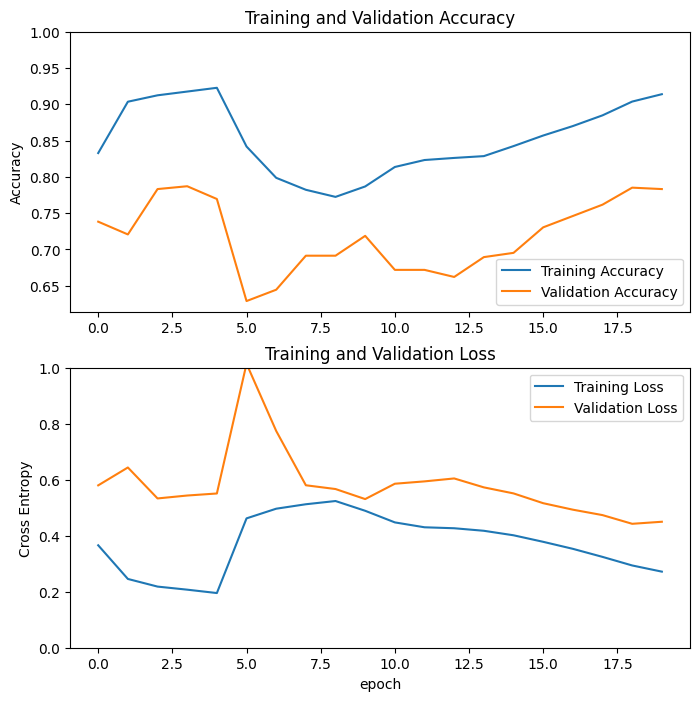

In [36]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('XFTceptionXRAY')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

XCEPTION SLOW TRANSFER

In [11]:
preprocess_input_XST = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XST = IMG_SIZE + (3,)
xception_model_XST = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XST,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XST.trainable = False
image_batch_XST, label_batch_XST = next(iter(train_dataset))
feature_batch_XST = xception_model_XST(image_batch_XST)
global_average_layer_XST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XST = global_average_layer_XST(feature_batch_XST)

'''fc1_layer_XST = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
fc1_batch_XST = fc1_layer_XST(feature_batch_average_XST)'''

prediction_layer_XST = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_XST = prediction_layer_XST(feature_batch_average_XST)

inputs_XST = tf.keras.Input(shape=(160, 160, 3))
x_XST = preprocess_input_XST(inputs_XST)
x_XST = xception_model_XST(x_XST)
x_XST = global_average_layer_XST(x_XST)
'''x_XST = tf.keras.layers.Dropout(0.2)(x_XST)
x_XST = fc1_layer_XST(x_XST)'''
x_XST = tf.keras.layers.Dropout(0.2)(x_XST)
outputs_XST = prediction_layer_XST(x_XST)
model_XST = tf.keras.Model(inputs_XST, outputs_XST)
model_XST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XST = "training_models/XRAY_XST.ckpt"
checkpoint_dir_XST = os.path.dirname(checkpoint_path_XST)
cp_callback_XST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XST,
                                                 save_weights_only=True,
                                                 verbose=0)

In [48]:
total_epochs_XST = 10
history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST])
initial_epochs_XST=total_epochs_XST
dumpHistory('XSTceptionXRAY', history_XST)

Epoch 1/10
163/163 [==============================] - 70s 402ms/step - loss: 0.3101 - accuracy: 0.8660 - val_loss: 0.5690 - val_accuracy: 0.7484
Epoch 2/10
163/163 [==============================] - 65s 392ms/step - loss: 0.2108 - accuracy: 0.9128 - val_loss: 0.5171 - val_accuracy: 0.7828
Epoch 3/10
163/163 [==============================] - 64s 390ms/step - loss: 0.1917 - accuracy: 0.9224 - val_loss: 0.6537 - val_accuracy: 0.7391
Epoch 4/10
163/163 [==============================] - 66s 398ms/step - loss: 0.1754 - accuracy: 0.9300 - val_loss: 0.5813 - val_accuracy: 0.7688
Epoch 5/10
163/163 [==============================] - 65s 396ms/step - loss: 0.1686 - accuracy: 0.9327 - val_loss: 0.6212 - val_accuracy: 0.7594
Epoch 6/10
163/163 [==============================] - 66s 397ms/step - loss: 0.1644 - accuracy: 0.9373 - val_loss: 0.5924 - val_accuracy: 0.7625
Epoch 7/10
163/163 [==============================] - 65s 396ms/step - loss: 0.1579 - accuracy: 0.9396 - val_loss: 0.5863 - val_ac

In [49]:
xception_model_XST.trainable = True
fine_tune_at_XST = 120
for layer_XST in xception_model_XST.layers[:fine_tune_at_XST]:
  layer_XST.trainable = False
model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XST = 2
total_epochs_XST =  initial_epochs_XST + fine_tune_epochs_XST

history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=initial_epochs_XST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST])
dumpHistory('XSTceptionXRAY', history_XST)
initial_epochs_XST += fine_tune_epochs_XST
for i in range (4):
  xception_model_XST.trainable = True
  fine_tune_at_XST -= 30
  for layer_XST in xception_model_XST.layers[:fine_tune_at_XST]:
    layer_XST.trainable = False
  model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XST = 2
  total_epochs_XST =  initial_epochs_XST + fine_tune_epochs_XST


  history_XST = model_XST.fit(train_dataset,
                          epochs=total_epochs_XST,
                          initial_epoch=initial_epochs_XST,
                          validation_data=validation_dataset, callbacks=[cp_callback_XST])
  dumpHistory('XSTceptionXRAY', history_XST)
  initial_epochs_XST+=fine_tune_epochs_XST

Epoch 11/12
163/163 [==============================] - 79s 457ms/step - loss: 0.4204 - accuracy: 0.9049 - val_loss: 0.8001 - val_accuracy: 0.6625
Epoch 12/12
163/163 [==============================] - 75s 453ms/step - loss: 0.3861 - accuracy: 0.9135 - val_loss: 0.5237 - val_accuracy: 0.7266
Epoch 13/14
163/163 [==============================] - 103s 603ms/step - loss: 0.4236 - accuracy: 0.8537 - val_loss: 0.4878 - val_accuracy: 0.7781
Epoch 14/14
163/163 [==============================] - 98s 596ms/step - loss: 0.3669 - accuracy: 0.8955 - val_loss: 0.4801 - val_accuracy: 0.7688
Epoch 15/16
163/163 [==============================] - 128s 757ms/step - loss: 0.4072 - accuracy: 0.8599 - val_loss: 0.4872 - val_accuracy: 0.7797
Epoch 16/16
163/163 [==============================] - 122s 739ms/step - loss: 0.3570 - accuracy: 0.8930 - val_loss: 0.4821 - val_accuracy: 0.7797
Epoch 17/18
163/163 [==============================] - 153s 903ms/step - loss: 0.4064 - accuracy: 0.8328 - val_loss: 0.45

In [50]:
model_XST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XST = 5
initial_epochs_XST = total_epochs_XST
total_epochs_XST =  initial_epochs_XST + add_epochs_XST

history_XST = model_XST.fit(train_dataset,
                         epochs=total_epochs_XST,
                         initial_epoch=initial_epochs_XST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XST, clr])
initial_epochs_XST+=add_epochs_XST
dumpHistory('XSTceptionXRAY', history_XST)

Epoch 21/25
163/163 [==============================] - 208s 1s/step - loss: 0.2584 - accuracy: 0.9208 - val_loss: 0.3801 - val_accuracy: 0.8359
Epoch 22/25
163/163 [==============================] - 202s 1s/step - loss: 0.2289 - accuracy: 0.9268 - val_loss: 0.3912 - val_accuracy: 0.8391
Epoch 23/25
163/163 [==============================] - 203s 1s/step - loss: 0.2004 - accuracy: 0.9362 - val_loss: 0.4221 - val_accuracy: 0.8109
Epoch 24/25
163/163 [==============================] - 204s 1s/step - loss: 0.1907 - accuracy: 0.9419 - val_loss: 0.4277 - val_accuracy: 0.8094
Epoch 25/25
163/163 [==============================] - 205s 1s/step - loss: 0.1824 - accuracy: 0.9444 - val_loss: 0.4194 - val_accuracy: 0.8234


2/2 [==============================] - 9s 672ms/step - loss: 0.5063 - accuracy: 0.8203


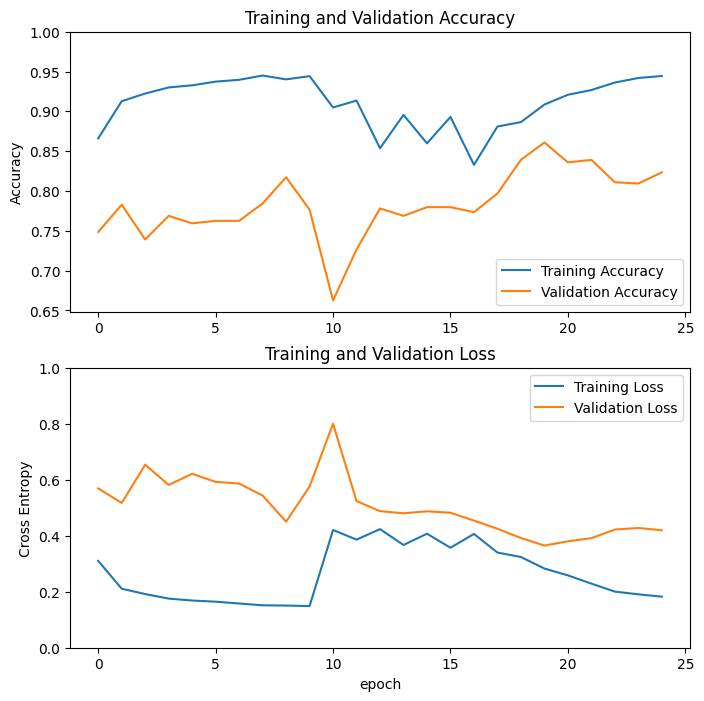

In [12]:
model_XST.load_weights("training_models/XRAY_XST.ckpt")
loss_XST, accuracy_XST = model_XST.evaluate(test_dataset)
acc_XST, val_acc_XST, loss_XST, val_loss_XST = loadHistory('XSTceptionXRAY')
distplayHistory(acc_XST, val_acc_XST, loss_XST, val_loss_XST)

XCEPTION PARTICAL TRSNSFER

In [10]:
preprocess_input_XPT = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XPT = IMG_SIZE + (3,)
xception_model_XPT = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XPT,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XPT.trainable = False
image_batch_XPT, label_batch_XPT = next(iter(train_dataset))
feature_batch_XPT = xception_model_XPT(image_batch_XPT)
global_average_layer_XPT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XPT = global_average_layer_XPT(feature_batch_XPT)
prediction_layer_XPT = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_XPT = prediction_layer_XPT(feature_batch_average_XPT)
inputs_XPT = tf.keras.Input(shape=(160, 160, 3))
x_XPT = preprocess_input_XPT(inputs_XPT)
x_XPT = xception_model_XPT(x_XPT)
x_XPT = global_average_layer_XPT(x_XPT)
x_XPT = tf.keras.layers.Dropout(0.2)(x_XPT)
outputs_XPT = prediction_layer_XPT(x_XPT)
model_XPT = tf.keras.Model(inputs_XPT, outputs_XPT)
model_XPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XPT = "training_models/XRAY_XPT.ckpt"
checkpoint_dir_XPT = os.path.dirname(checkpoint_path_XPT)
cp_callback_XPT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XPT,
                                                 save_weights_only=True,
                                                 verbose=0)

In [11]:
total_epochs_XPT = 20
history_XPT = model_XPT.fit(train_dataset,
                         epochs=total_epochs_XPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_XPT])
initial_epochs_XPT=total_epochs_XPT
dumpHistory('XPTceptionXRAY', history_XPT)

Epoch 1/20
82/82 [==============================] - 77s 825ms/step - loss: 0.3552 - accuracy: 0.8384 - val_loss: 0.5565 - val_accuracy: 0.7305
Epoch 2/20
82/82 [==============================] - 66s 780ms/step - loss: 0.2338 - accuracy: 0.9076 - val_loss: 0.5019 - val_accuracy: 0.7734
Epoch 3/20
82/82 [==============================] - 66s 779ms/step - loss: 0.2169 - accuracy: 0.9178 - val_loss: 0.5796 - val_accuracy: 0.7598
Epoch 4/20
82/82 [==============================] - 65s 776ms/step - loss: 0.2004 - accuracy: 0.9212 - val_loss: 0.4856 - val_accuracy: 0.7871
Epoch 5/20
82/82 [==============================] - 66s 779ms/step - loss: 0.1899 - accuracy: 0.9248 - val_loss: 0.4790 - val_accuracy: 0.7891
Epoch 6/20
82/82 [==============================] - 66s 779ms/step - loss: 0.1835 - accuracy: 0.9291 - val_loss: 0.4173 - val_accuracy: 0.8242
Epoch 7/20
82/82 [==============================] - 66s 779ms/step - loss: 0.1803 - accuracy: 0.9291 - val_loss: 0.5292 - val_accuracy: 0.7676

In [12]:
checkpoint_path_XPT = "training_models/XRAY_XFPT.ckpt"
checkpoint_dir_XPT = os.path.dirname(checkpoint_path_XPT)
cp_callback_XPT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XPT,
                                                 save_weights_only=True,
                                                 verbose=0)
model_XPT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
total_epochs_XPT = 40
history_XPT = model_XPT.fit(train_dataset,
                         epochs=total_epochs_XPT,
                         initial_epoch=initial_epochs_XPT,
                         validation_data=validation_dataset, callbacks=[cp_callback_XPT, clr])
dumpHistory('XPTceptionXRAY', history_XPT)

Epoch 21/40
82/82 [==============================] - 70s 799ms/step - loss: 0.1415 - accuracy: 0.9429 - val_loss: 0.5629 - val_accuracy: 0.7734
Epoch 22/40
82/82 [==============================] - 66s 784ms/step - loss: 0.1428 - accuracy: 0.9452 - val_loss: 0.5128 - val_accuracy: 0.7891
Epoch 23/40
82/82 [==============================] - 66s 786ms/step - loss: 0.1425 - accuracy: 0.9465 - val_loss: 0.4841 - val_accuracy: 0.8105
Epoch 24/40
82/82 [==============================] - 66s 786ms/step - loss: 0.1420 - accuracy: 0.9477 - val_loss: 0.4653 - val_accuracy: 0.8125
Epoch 25/40
82/82 [==============================] - 66s 785ms/step - loss: 0.1429 - accuracy: 0.9463 - val_loss: 0.4148 - val_accuracy: 0.8340
Epoch 26/40
82/82 [==============================] - 65s 776ms/step - loss: 0.1465 - accuracy: 0.9456 - val_loss: 0.5062 - val_accuracy: 0.8047
Epoch 27/40
82/82 [==============================] - 61s 728ms/step - loss: 0.1427 - accuracy: 0.9461 - val_loss: 0.5019 - val_accuracy:

2/2 [==============================] - 3s 675ms/step - loss: 0.5123 - accuracy: 0.8047


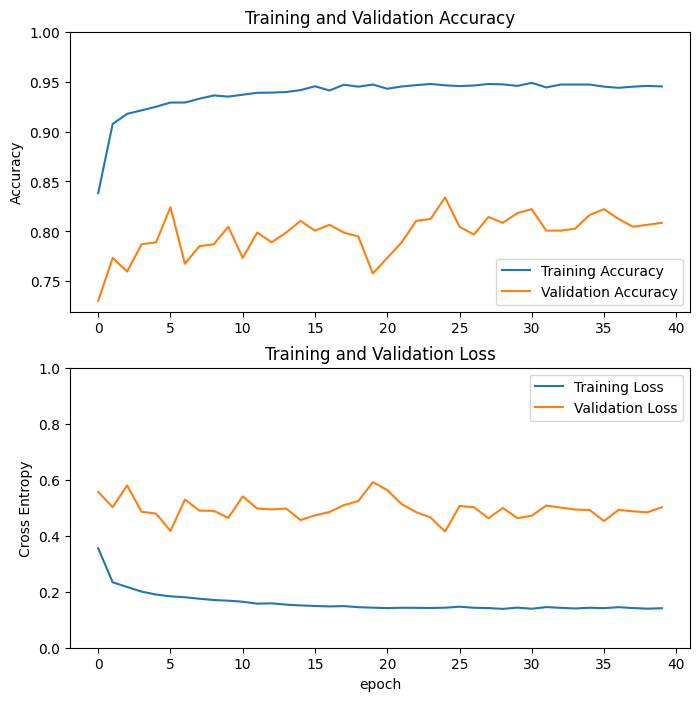

In [13]:
loss_XPT, accuracy_XPT = model_XPT.evaluate(test_dataset)
acc_XPT, val_acc_XPT, loss_XPT, val_loss_XPT = loadHistory('XPTceptionXRAY')
distplayHistory(acc_XPT, val_acc_XPT, loss_XPT, val_loss_XPT)

XCEPTION VERY SLOW TRANSFER

In [14]:
preprocess_input_XVST = tf.keras.applications.xception.preprocess_input
IMG_SHAPE_XVST = IMG_SIZE + (3,)
xception_model_XVST = tf.keras.applications.Xception(input_shape=IMG_SHAPE_XVST,
                                               include_top=False,
                                               weights='imagenet')
xception_model_XVST.trainable = False
image_batch_XVST, label_batch_XVST = next(iter(train_dataset))
feature_batch_XVST = xception_model_XVST(image_batch_XVST)
global_average_layer_XVST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_XVST = global_average_layer_XVST(feature_batch_XVST)
prediction_layer_XVST = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_XVST = prediction_layer_XVST(feature_batch_average_XVST)
inputs_XVST = tf.keras.Input(shape=(160, 160, 3))
x_XVST = preprocess_input_XVST(inputs_XVST)
x_XVST = xception_model_XVST(x_XVST)
x_XVST = global_average_layer_XVST(x_XVST)
x_XVST = tf.keras.layers.Dropout(0.2)(x_XVST)
outputs_XVST = prediction_layer_XVST(x_XVST)
model_XVST = tf.keras.Model(inputs_XVST, outputs_XVST)
model_XVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_XVST = "training_models/XRAY_XVST.ckpt"
checkpoint_dir_XVST = os.path.dirname(checkpoint_path_XVST)
cp_callback_XVST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_XVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [15]:
model_XVST.load_weights("training_models/XRAY_XPT.ckpt")
total_epochs_XVST = 30
initial_epochs_XVST = 20
xception_model_XVST.trainable = True
fine_tune_at_XVST = 144
for layer_XVST in xception_model_XVST.layers[:fine_tune_at_XVST]:
  layer_XVST.trainable = False
model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_XVST = 1
total_epochs_XVST =  initial_epochs_XVST + fine_tune_epochs_XVST

history_XVST = model_XVST.fit(train_dataset,
                         epochs=total_epochs_XVST,
                         initial_epoch=initial_epochs_XVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XVST])
dumpHistory('XVSTceptionXRAY', history_XVST)
initial_epochs_XVST += fine_tune_epochs_XVST
for i in range (9):
  xception_model_XVST.trainable = True
  fine_tune_at_XVST -= 16
  for layer_XVST in xception_model_XVST.layers[:fine_tune_at_XVST]:
    layer_XVST.trainable = False
  model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_XVST = 1
  total_epochs_XVST =  initial_epochs_XVST + fine_tune_epochs_XVST


  history_XVST = model_XVST.fit(train_dataset,
                          epochs=total_epochs_XVST,
                          initial_epoch=initial_epochs_XVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_XVST])
  dumpHistory('XVSTceptionXRAY', history_XVST)
  initial_epochs_XVST+=fine_tune_epochs_XVST

Epoch 21/21
82/82 [==============================] - 66s 746ms/step - loss: 0.1425 - accuracy: 0.9454 - val_loss: 0.4434 - val_accuracy: 0.8203
Epoch 22/22
82/82 [==============================] - 70s 786ms/step - loss: 0.2332 - accuracy: 0.9362 - val_loss: 0.4020 - val_accuracy: 0.8066
Epoch 23/23
82/82 [==============================] - 82s 933ms/step - loss: 0.4095 - accuracy: 0.8896 - val_loss: 0.5950 - val_accuracy: 0.7324
Epoch 24/24
82/82 [==============================] - 92s 1s/step - loss: 0.4392 - accuracy: 0.8531 - val_loss: 0.6982 - val_accuracy: 0.7188
Epoch 25/25
82/82 [==============================] - 103s 1s/step - loss: 0.4261 - accuracy: 0.8600 - val_loss: 0.5540 - val_accuracy: 0.7207
Epoch 26/26
82/82 [==============================] - 111s 1s/step - loss: 0.4494 - accuracy: 0.8355 - val_loss: 0.5219 - val_accuracy: 0.7324
Epoch 27/27
82/82 [==============================] - 135s 2s/step - loss: 0.4472 - accuracy: 0.8359 - val_loss: 0.4650 - val_accuracy: 0.7734
E

In [16]:
model_XVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_XVST = 5
initial_epochs_XVST = total_epochs_XVST
total_epochs_XVST =  initial_epochs_XVST + add_epochs_XVST

history_XVST = model_XVST.fit(train_dataset,
                         epochs=total_epochs_XVST,
                         initial_epoch=initial_epochs_XVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_XVST, clr])
initial_epochs_XVST+=add_epochs_XVST
dumpHistory('XVSTceptionXRAY', history_XVST)

Epoch 31/35
82/82 [==============================] - 209s 2s/step - loss: 0.3504 - accuracy: 0.8878 - val_loss: 0.4215 - val_accuracy: 0.8203
Epoch 32/35
82/82 [==============================] - 203s 2s/step - loss: 0.3156 - accuracy: 0.9020 - val_loss: 0.4184 - val_accuracy: 0.8184
Epoch 33/35
82/82 [==============================] - 207s 2s/step - loss: 0.2950 - accuracy: 0.9110 - val_loss: 0.4935 - val_accuracy: 0.7695
Epoch 34/35
82/82 [==============================] - 193s 2s/step - loss: 0.2808 - accuracy: 0.9149 - val_loss: 0.4825 - val_accuracy: 0.7656
Epoch 35/35
82/82 [==============================] - 179s 2s/step - loss: 0.2756 - accuracy: 0.9185 - val_loss: 0.4616 - val_accuracy: 0.7734


2/2 [==============================] - 3s 584ms/step - loss: 0.4176 - accuracy: 0.7969


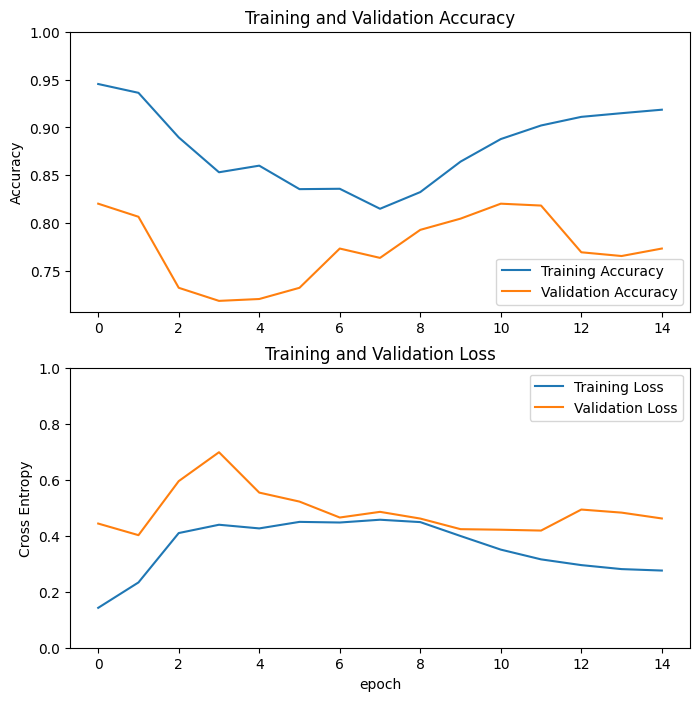

In [17]:
loss_XVST, accuracy_XVST = model_XVST.evaluate(test_dataset)
acc_XVST, val_acc_XVST, loss_XVST, val_loss_XVST = loadHistory('XVSTceptionXRAY')
distplayHistory(acc_XVST, val_acc_XVST, loss_XVST, val_loss_XVST)

VGG-16

VGG-16 NO TRANSFER

In [80]:
preprocess_input_VNT = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VNT = IMG_SIZE + (3,)
xception_model_VNT = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VNT,
                                               include_top=False)
image_batch_VNT, label_batch_VNT = next(iter(train_dataset))
feature_batch_VNT = xception_model_VNT(image_batch_VNT)

global_average_layer_VNT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VNT = global_average_layer_VNT(feature_batch_VNT)

fc1_layer_VNT = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc1_batch_VNT = fc1_layer_VNT(feature_batch_average_VNT)

fc2_layer_VNT = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc2_batch_VNT = fc2_layer_VNT(fc1_batch_VNT)

prediction_layer_VNT = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_VNT = prediction_layer_VNT(fc2_batch_VNT)

inputs_VNT = tf.keras.Input(shape=(160, 160, 3))
x_VNT = preprocess_input_VNT(inputs_VNT)
x_VNT = xception_model_VNT(x_VNT)
x_VNT = global_average_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
x_VNT = fc1_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
x_VNT = fc2_layer_VNT(x_VNT)
x_VNT = tf.keras.layers.Dropout(0.2)(x_VNT)
outputs_VNT = prediction_layer_VNT(x_VNT)
model_VNT = tf.keras.Model(inputs_VNT, outputs_VNT)
model_VNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VNT = "training_models/XRAY_VNT.ckpt"
checkpoint_dir_VNT = os.path.dirname(checkpoint_path_VNT)
cp_callback_VNT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [81]:
total_epochs_VNT = 10
history_VNT = model_VNT.fit(train_dataset,
                         epochs=total_epochs_VNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VNT])
initial_epochs_VNT=total_epochs_VNT
dumpHistory('VNTvgg16XRAY', history_VNT)

Epoch 1/10
82/82 [==============================] - 173s 2s/step - loss: 0.4209 - accuracy: 0.8468 - val_loss: 0.7070 - val_accuracy: 0.7422
Epoch 2/10
82/82 [==============================] - 171s 2s/step - loss: 0.1372 - accuracy: 0.9494 - val_loss: 0.6056 - val_accuracy: 0.7969
Epoch 3/10
82/82 [==============================] - 171s 2s/step - loss: 0.1131 - accuracy: 0.9551 - val_loss: 0.5088 - val_accuracy: 0.8516
Epoch 4/10
82/82 [==============================] - 171s 2s/step - loss: 0.0694 - accuracy: 0.9737 - val_loss: 0.4800 - val_accuracy: 0.8555
Epoch 5/10
82/82 [==============================] - 171s 2s/step - loss: 0.0583 - accuracy: 0.9806 - val_loss: 1.2889 - val_accuracy: 0.7637
Epoch 6/10
82/82 [==============================] - 173s 2s/step - loss: 0.0395 - accuracy: 0.9866 - val_loss: 1.8615 - val_accuracy: 0.7207
Epoch 7/10
82/82 [==============================] - 171s 2s/step - loss: 0.0343 - accuracy: 0.9893 - val_loss: 1.1569 - val_accuracy: 0.7695
Epoch 8/10
82

In [82]:
model_VNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VNT = 10
total_epochs_VNT =  initial_epochs_VNT + add_epochs_VNT

history_VNT = model_VNT.fit(train_dataset,
                         epochs=total_epochs_VNT,
                         initial_epoch=initial_epochs_VNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VNT, clr])
initial_epochs_VNT+=add_epochs_VNT
dumpHistory('VNTvgg16XRAY', history_VNT)

Epoch 11/20
82/82 [==============================] - 178s 2s/step - loss: 0.0261 - accuracy: 0.9908 - val_loss: 1.3144 - val_accuracy: 0.7695
Epoch 12/20
82/82 [==============================] - 170s 2s/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 1.4929 - val_accuracy: 0.7520
Epoch 13/20
82/82 [==============================] - 171s 2s/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 1.5193 - val_accuracy: 0.7461
Epoch 14/20
82/82 [==============================] - 171s 2s/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 1.4999 - val_accuracy: 0.7637
Epoch 15/20
82/82 [==============================] - 170s 2s/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 1.5713 - val_accuracy: 0.7539
Epoch 16/20
82/82 [==============================] - 170s 2s/step - loss: 0.0122 - accuracy: 0.9969 - val_loss: 1.6519 - val_accuracy: 0.7480
Epoch 17/20
82/82 [==============================] - 171s 2s/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 1.5674 - val_accuracy: 0.7539
Epoch 

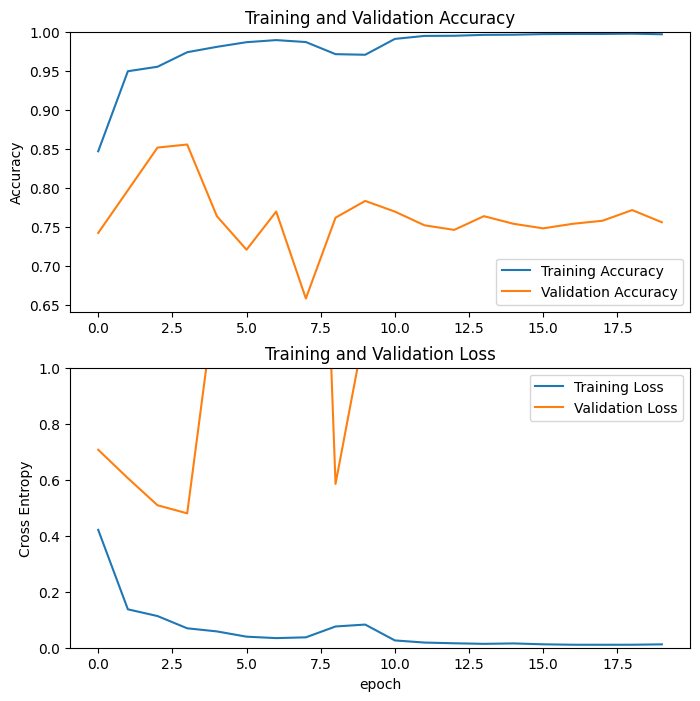

In [83]:
acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT = loadHistory('VNTvgg16XRAY')
distplayHistory(acc_XFT, val_acc_XFT, loss_XFT, val_loss_XFT)

In [84]:
loss4, accuracy4 = model_VNT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss4))
print("Test accuracy: {:.4f}".format(accuracy4))

2/2 [==============================] - 3s 579ms/step - loss: 1.3174 - accuracy: 0.7734
Test loss: 1.3174
Test accuracy: 0.7734


VGG16 FAST TRANSFER

In [87]:
preprocess_input_VFT = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VFT = IMG_SIZE + (3,)
vgg16_model_VFT = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VFT,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VFT.trainable = False
image_batch_VFT, label_batch_VFT = next(iter(train_dataset))
feature_batch_VFT = vgg16_model_VFT(image_batch_VFT)

global_average_layer_VFT = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VFT = global_average_layer_VFT(feature_batch_VFT)

fc1_layer_VFT = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc1_batch_VFT = fc1_layer_VFT(feature_batch_average_VFT)

fc2_layer_VFT = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc2_batch_VFT = fc2_layer_VFT(fc1_batch_VFT)

prediction_layer_VFT = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_VFT = prediction_layer_VFT(fc2_batch_VFT)

inputs_VFT = tf.keras.Input(shape=(160, 160, 3))
x_VFT = preprocess_input_VFT(inputs_VFT)
x_VFT = vgg16_model_VFT(x_VFT)
x_VFT = global_average_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
x_VFT = fc1_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
x_VFT = fc2_layer_VFT(x_VFT)
x_VFT = tf.keras.layers.Dropout(0.2)(x_VFT)
outputs_VFT = prediction_layer_VFT(x_VFT)
model_VFT = tf.keras.Model(inputs_VFT, outputs_VFT)
model_VFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VFT = "training_models/XRAY_VFT.ckpt"
checkpoint_dir_VFT = os.path.dirname(checkpoint_path_VFT)
cp_callback_VFT = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VFT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [88]:
total_epochs_VFT = 5
history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT])
initial_epochs_VFT=total_epochs_VFT
dumpHistory('VFTvgg16XRAY', history_VFT)

Epoch 1/5
82/82 [==============================] - 61s 708ms/step - loss: 0.7018 - accuracy: 0.8000 - val_loss: 0.7911 - val_accuracy: 0.7305
Epoch 2/5
82/82 [==============================] - 58s 688ms/step - loss: 0.3595 - accuracy: 0.8646 - val_loss: 0.5967 - val_accuracy: 0.7734
Epoch 3/5
82/82 [==============================] - 58s 689ms/step - loss: 0.2712 - accuracy: 0.8959 - val_loss: 0.6188 - val_accuracy: 0.7656
Epoch 4/5
82/82 [==============================] - 59s 693ms/step - loss: 0.2446 - accuracy: 0.9041 - val_loss: 0.5183 - val_accuracy: 0.7910
Epoch 5/5
82/82 [==============================] - 58s 692ms/step - loss: 0.2424 - accuracy: 0.9089 - val_loss: 0.5244 - val_accuracy: 0.7793


In [89]:
vgg16_model_VFT.trainable = True
fine_tune_at_VFT = 16
for layer_VFT in vgg16_model_VFT.layers[:fine_tune_at_VFT]:
  layer_VFT.trainable = False
model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VFT = 1
total_epochs_VFT =  initial_epochs_VFT + fine_tune_epochs_VFT

history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=initial_epochs_VFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT])
dumpHistory('VFTvgg16XRAY', history_VFT)
initial_epochs_VFT += fine_tune_epochs_VFT
for i in range (4):
  vgg16_model_VFT.trainable = True
  fine_tune_at_VFT -= 4
  for layer_VFT in vgg16_model_VFT.layers[:fine_tune_at_VFT]:
    layer_VFT.trainable = False
  model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VFT = 1
  total_epochs_VFT =  initial_epochs_VFT + fine_tune_epochs_VFT


  history_VFT = model_VFT.fit(train_dataset,
                          epochs=total_epochs_VFT,
                          initial_epoch=initial_epochs_VFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_VFT])
  dumpHistory('VFTvgg16XRAY', history_VFT)
  initial_epochs_VFT+=fine_tune_epochs_VFT


Epoch 6/6
82/82 [==============================] - 65s 751ms/step - loss: 0.1929 - accuracy: 0.9235 - val_loss: 0.6066 - val_accuracy: 0.7637
Epoch 7/7
82/82 [==============================] - 80s 941ms/step - loss: 0.1535 - accuracy: 0.9433 - val_loss: 0.6185 - val_accuracy: 0.7871
Epoch 8/8
82/82 [==============================] - 103s 1s/step - loss: 0.1145 - accuracy: 0.9574 - val_loss: 0.3507 - val_accuracy: 0.8594
Epoch 9/9
82/82 [==============================] - 139s 2s/step - loss: 0.0936 - accuracy: 0.9653 - val_loss: 0.6675 - val_accuracy: 0.8086
Epoch 10/10
82/82 [==============================] - 174s 2s/step - loss: 0.0770 - accuracy: 0.9724 - val_loss: 0.9548 - val_accuracy: 0.7578


In [90]:
model_VFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VFT = 10
total_epochs_VFT =  initial_epochs_VFT + add_epochs_VFT

history_VFT = model_VFT.fit(train_dataset,
                         epochs=total_epochs_VFT,
                         initial_epoch=initial_epochs_VFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VFT, clr])
initial_epochs_VFT+=add_epochs_VFT
dumpHistory('VFTvgg16XRAY', history_VFT)

Epoch 11/20
82/82 [==============================] - 174s 2s/step - loss: 0.0763 - accuracy: 0.9737 - val_loss: 1.4426 - val_accuracy: 0.7012
Epoch 12/20
82/82 [==============================] - 174s 2s/step - loss: 0.0678 - accuracy: 0.9758 - val_loss: 0.8523 - val_accuracy: 0.7930
Epoch 13/20
82/82 [==============================] - 173s 2s/step - loss: 0.0592 - accuracy: 0.9789 - val_loss: 0.5420 - val_accuracy: 0.8496
Epoch 14/20
82/82 [==============================] - 173s 2s/step - loss: 0.0697 - accuracy: 0.9760 - val_loss: 0.6059 - val_accuracy: 0.8242
Epoch 15/20
82/82 [==============================] - 172s 2s/step - loss: 0.0417 - accuracy: 0.9849 - val_loss: 0.7697 - val_accuracy: 0.8281
Epoch 16/20
82/82 [==============================] - 173s 2s/step - loss: 0.0453 - accuracy: 0.9827 - val_loss: 0.8249 - val_accuracy: 0.8242
Epoch 17/20
82/82 [==============================] - 172s 2s/step - loss: 0.0343 - accuracy: 0.9879 - val_loss: 1.0688 - val_accuracy: 0.8027
Epoch 

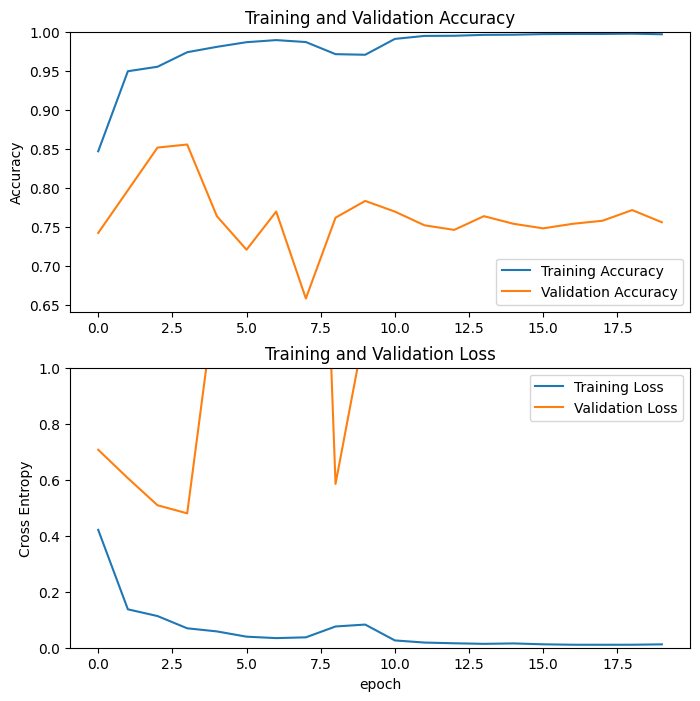

2/2 [==============================] - 3s 595ms/step - loss: 0.8972 - accuracy: 0.8125
Test loss: 0.8972
Test accuracy: 0.8125


In [91]:
acc_VFT, val_acc_VFT, loss_VFT, val_loss_VFT = loadHistory('VNTvgg16XRAY')
distplayHistory(acc_VFT, val_acc_VFT, loss_VFT, val_loss_VFT)
loss5, accuracy5 = model_VFT.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss5))
print("Test accuracy: {:.4f}".format(accuracy5))

VGG16 SLOW TRANSFER

In [13]:
preprocess_input_VST = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VST = IMG_SIZE + (3,)
vgg16_model_VST = tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VST,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VST.trainable = False
image_batch_VST, label_batch_VST = next(iter(train_dataset))
feature_batch_VST = vgg16_model_VST(image_batch_VST)

global_average_layer_VST = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VST = global_average_layer_VST(feature_batch_VST)

fc1_layer_VST = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc1_batch_VST = fc1_layer_VST(feature_batch_average_VST)

fc2_layer_VST = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc2_batch_VST = fc2_layer_VST(fc1_batch_VST)

prediction_layer_VST = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_VST = prediction_layer_VST(fc2_batch_VST)

inputs_VST = tf.keras.Input(shape=(160, 160, 3))
x_VST = preprocess_input_VST(inputs_VST)
x_VST = vgg16_model_VST(x_VST)
x_VST = global_average_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
x_VST = fc1_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
x_VST = fc2_layer_VST(x_VST)
x_VST = tf.keras.layers.Dropout(0.2)(x_VST)
outputs_VST = prediction_layer_VST(x_VST)
model_VST = tf.keras.Model(inputs_VST, outputs_VST)
model_VST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VST = "training_models/XRAY_VST.ckpt"
checkpoint_dir_VST = os.path.dirname(checkpoint_path_VST)
cp_callback_VST = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [93]:
total_epochs_VST = 10
history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST])
initial_epochs_VST=total_epochs_VST
dumpHistory('VSTvgg16XRAY', history_VST)

Epoch 1/10
82/82 [==============================] - 58s 676ms/step - loss: 0.6854 - accuracy: 0.8121 - val_loss: 0.3783 - val_accuracy: 0.8359
Epoch 2/10
82/82 [==============================] - 57s 675ms/step - loss: 0.3417 - accuracy: 0.8706 - val_loss: 0.4969 - val_accuracy: 0.7930
Epoch 3/10
82/82 [==============================] - 58s 683ms/step - loss: 0.2784 - accuracy: 0.8926 - val_loss: 0.5023 - val_accuracy: 0.7812
Epoch 4/10
82/82 [==============================] - 58s 682ms/step - loss: 0.2477 - accuracy: 0.9062 - val_loss: 0.4866 - val_accuracy: 0.7910
Epoch 5/10
82/82 [==============================] - 58s 681ms/step - loss: 0.2244 - accuracy: 0.9145 - val_loss: 0.4430 - val_accuracy: 0.8027
Epoch 6/10
82/82 [==============================] - 58s 679ms/step - loss: 0.2081 - accuracy: 0.9210 - val_loss: 0.4567 - val_accuracy: 0.7969
Epoch 7/10
82/82 [==============================] - 58s 684ms/step - loss: 0.1913 - accuracy: 0.9222 - val_loss: 0.4919 - val_accuracy: 0.7949

In [94]:
vgg16_model_VST.trainable = True
fine_tune_at_VST = 16
for layer_VST in vgg16_model_VST.layers[:fine_tune_at_VST]:
  layer_VST.trainable = False
model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VST = 2
total_epochs_VST =  initial_epochs_VST + fine_tune_epochs_VST

history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=initial_epochs_VST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST])
dumpHistory('VSTvgg16XRAY', history_VST)
initial_epochs_VST += fine_tune_epochs_VST
for i in range (4):
  vgg16_model_VST.trainable = True
  fine_tune_at_VST -= 4
  for layer_VST in vgg16_model_VST.layers[:fine_tune_at_VST]:
    layer_VST.trainable = False
  model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VST = 2
  total_epochs_VST =  initial_epochs_VST + fine_tune_epochs_VST


  history_VST = model_VST.fit(train_dataset,
                          epochs=total_epochs_VST,
                          initial_epoch=initial_epochs_VST,
                          validation_data=validation_dataset, callbacks=[cp_callback_VST])
  dumpHistory('VSTvgg16XRAY', history_VST)
  initial_epochs_VST+=fine_tune_epochs_VST


Epoch 11/12
82/82 [==============================] - 63s 734ms/step - loss: 0.1549 - accuracy: 0.9387 - val_loss: 0.4236 - val_accuracy: 0.8281
Epoch 12/12
82/82 [==============================] - 61s 728ms/step - loss: 0.1340 - accuracy: 0.9480 - val_loss: 0.5041 - val_accuracy: 0.8008
Epoch 13/14
82/82 [==============================] - 78s 919ms/step - loss: 0.1169 - accuracy: 0.9523 - val_loss: 0.5107 - val_accuracy: 0.8203
Epoch 14/14
82/82 [==============================] - 77s 913ms/step - loss: 0.1012 - accuracy: 0.9611 - val_loss: 0.8685 - val_accuracy: 0.7500
Epoch 15/16
82/82 [==============================] - 101s 1s/step - loss: 0.0912 - accuracy: 0.9668 - val_loss: 0.4578 - val_accuracy: 0.8418
Epoch 16/16
82/82 [==============================] - 97s 1s/step - loss: 0.0711 - accuracy: 0.9718 - val_loss: 0.7836 - val_accuracy: 0.7832
Epoch 17/18
82/82 [==============================] - 128s 2s/step - loss: 0.0678 - accuracy: 0.9747 - val_loss: 0.6192 - val_accuracy: 0.8262

In [95]:
model_VST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VST = 5
total_epochs_VST =  initial_epochs_VST + add_epochs_VST

history_VST = model_VST.fit(train_dataset,
                         epochs=total_epochs_VST,
                         initial_epoch=initial_epochs_VST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VST, clr])
initial_epochs_VST+=add_epochs_VST
dumpHistory('VSTvgg16XRAY', history_VST)

Epoch 21/25
82/82 [==============================] - 161s 2s/step - loss: 0.0445 - accuracy: 0.9831 - val_loss: 0.8029 - val_accuracy: 0.8027
Epoch 22/25
82/82 [==============================] - 159s 2s/step - loss: 0.0381 - accuracy: 0.9873 - val_loss: 0.7956 - val_accuracy: 0.8223
Epoch 23/25
82/82 [==============================] - 159s 2s/step - loss: 0.0410 - accuracy: 0.9849 - val_loss: 0.5556 - val_accuracy: 0.8574
Epoch 24/25
82/82 [==============================] - 159s 2s/step - loss: 0.0392 - accuracy: 0.9841 - val_loss: 0.8536 - val_accuracy: 0.8066
Epoch 25/25
82/82 [==============================] - 159s 2s/step - loss: 0.0366 - accuracy: 0.9862 - val_loss: 0.5181 - val_accuracy: 0.8691


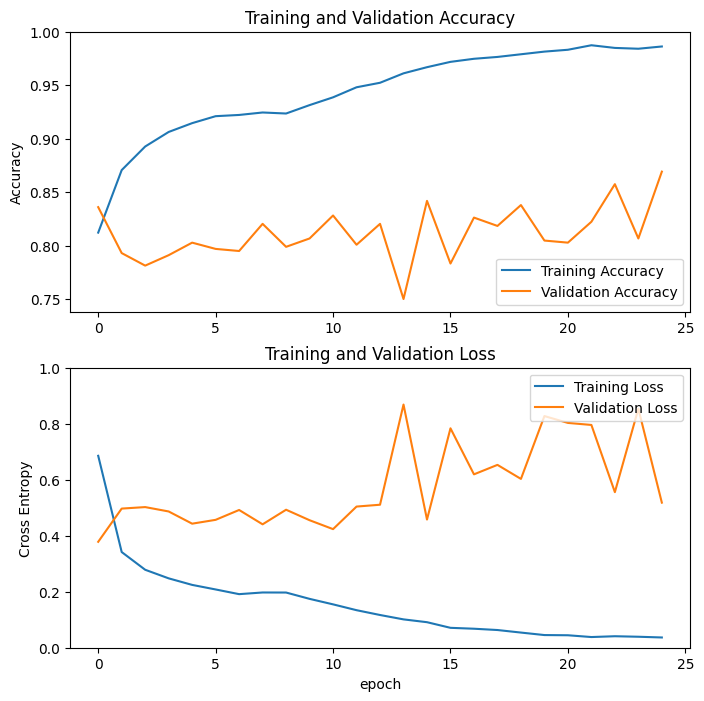

2/2 [==============================] - 3s 571ms/step - loss: 1.3091 - accuracy: 0.6719
Test loss: 1.3091
Test accuracy: 0.6719


In [16]:
acc_VST, val_acc_VST, loss_VST, val_loss_VST = loadHistory('VSTvgg16XRAY')
distplayHistory(acc_VST, val_acc_VST, loss_VST, val_loss_VST)
loss5, accuracy5 = model_VST.evaluate(test_dataset)
print("Test loss: {:.4f}".format(loss5))
print("Test accuracy: {:.4f}".format(accuracy5))

VGG PARTICAL TRANSFER

In [15]:
preprocess_input_VPT= tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VPT= IMG_SIZE + (3,)
vgg16_model_VPT= tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VPT,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VPT.trainable = False
image_batch_VPT, label_batch_VPT= next(iter(train_dataset))
feature_batch_VPT= vgg16_model_VPT(image_batch_VPT)

global_average_layer_VPT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VPT= global_average_layer_VPT(feature_batch_VPT)

fc1_layer_VPT= tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc1_batch_VPT= fc1_layer_VPT(feature_batch_average_VPT)

fc2_layer_VPT= tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc2_batch_VPT= fc2_layer_VPT(fc1_batch_VPT)

prediction_layer_VPT= tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_VPT= prediction_layer_VPT(fc2_batch_VPT)

inputs_VPT= tf.keras.Input(shape=(160, 160, 3))
x_VPT= preprocess_input_VPT(inputs_VPT)
x_VPT= vgg16_model_VPT(x_VPT)
x_VPT= global_average_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
x_VPT= fc1_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
x_VPT= fc2_layer_VPT(x_VPT)
x_VPT= tf.keras.layers.Dropout(0.2)(x_VPT)
outputs_VPT= prediction_layer_VPT(x_VPT)
model_VPT= tf.keras.Model(inputs_VPT, outputs_VPT)
model_VPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VPT= "training_models/XRAY_VPT.ckpt"
checkpoint_dir_VPT= os.path.dirname(checkpoint_path_VPT)
cp_callback_VPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VPT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [20]:
total_epochs_VPT = 20
history_VPT = model_VPT.fit(train_dataset,
                         epochs=total_epochs_VPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_VPT])
initial_epochs_VPT=total_epochs_VPT
dumpHistory('VPTvgg16XRAY', history_VPT)

Epoch 1/20
82/82 [==============================] - 89s 827ms/step - loss: 0.7523 - accuracy: 0.8066 - val_loss: 0.7590 - val_accuracy: 0.7246
Epoch 2/20
82/82 [==============================] - 57s 672ms/step - loss: 0.3600 - accuracy: 0.8740 - val_loss: 0.5159 - val_accuracy: 0.7695
Epoch 3/20
82/82 [==============================] - 55s 656ms/step - loss: 0.2622 - accuracy: 0.8957 - val_loss: 0.6187 - val_accuracy: 0.7676
Epoch 4/20
82/82 [==============================] - 56s 658ms/step - loss: 0.2291 - accuracy: 0.9141 - val_loss: 0.4068 - val_accuracy: 0.8281
Epoch 5/20
82/82 [==============================] - 56s 658ms/step - loss: 0.2304 - accuracy: 0.9093 - val_loss: 0.5765 - val_accuracy: 0.7793
Epoch 6/20
82/82 [==============================] - 56s 661ms/step - loss: 0.2110 - accuracy: 0.9153 - val_loss: 0.5322 - val_accuracy: 0.7832
Epoch 7/20
82/82 [==============================] - 56s 661ms/step - loss: 0.1944 - accuracy: 0.9218 - val_loss: 0.4869 - val_accuracy: 0.8047

In [21]:
checkpoint_path_VPT= "training_models/XRAY_VFPT.ckpt"
checkpoint_dir_VPT= os.path.dirname(checkpoint_path_VPT)
cp_callback_VPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VPT,
                                                 save_weights_only=True,
                                                 verbose=0)
total_epochs_VPT = 40
history_VPT = model_VPT.fit(train_dataset,
                         epochs=total_epochs_VPT,
                         initial_epoch=initial_epochs_VPT,
                         validation_data=validation_dataset, callbacks=[cp_callback_VPT, clr])
dumpHistory('VPTvgg16XRAY', history_VPT)

Epoch 21/40
82/82 [==============================] - 57s 668ms/step - loss: 0.1470 - accuracy: 0.9404 - val_loss: 0.5648 - val_accuracy: 0.7910
Epoch 22/40
82/82 [==============================] - 57s 664ms/step - loss: 0.1437 - accuracy: 0.9444 - val_loss: 0.5349 - val_accuracy: 0.8027
Epoch 23/40
82/82 [==============================] - 56s 657ms/step - loss: 0.1321 - accuracy: 0.9486 - val_loss: 0.4862 - val_accuracy: 0.8184
Epoch 24/40
82/82 [==============================] - 56s 656ms/step - loss: 0.1340 - accuracy: 0.9498 - val_loss: 0.5344 - val_accuracy: 0.8047
Epoch 25/40
82/82 [==============================] - 56s 660ms/step - loss: 0.1384 - accuracy: 0.9461 - val_loss: 0.5488 - val_accuracy: 0.7949
Epoch 26/40
82/82 [==============================] - 56s 658ms/step - loss: 0.1438 - accuracy: 0.9452 - val_loss: 0.5678 - val_accuracy: 0.8027
Epoch 27/40
82/82 [==============================] - 56s 659ms/step - loss: 0.1360 - accuracy: 0.9467 - val_loss: 0.5838 - val_accuracy:

2/2 [==============================] - 3s 503ms/step - loss: 0.4273 - accuracy: 0.8047


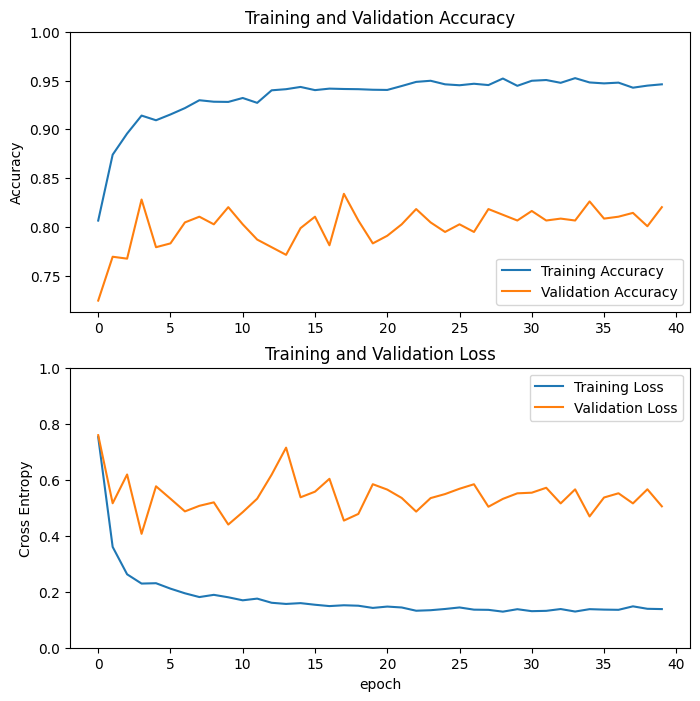

In [22]:
model_VPT.load_weights("training_models/XRAY_VPT.ckpt")
loss_VPT, accuracy_VPT = model_VPT.evaluate(test_dataset)
acc_VPT, val_acc_VPT, loss_VPT, val_loss_VPT = loadHistory('VPTvgg16XRAY')
distplayHistory(acc_VPT, val_acc_VPT, loss_VPT, val_loss_VPT)

VGG16 VERY SLOW TRANSFER

In [23]:
preprocess_input_VVST= tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE_VVST= IMG_SIZE + (3,)
vgg16_model_VVST= tf.keras.applications.VGG16(input_shape=IMG_SHAPE_VVST,
                                               include_top=False,
                                               weights='imagenet')
vgg16_model_VVST.trainable = False
image_batch_VVST, label_batch_VVST= next(iter(train_dataset))
feature_batch_VVST= vgg16_model_VVST(image_batch_VVST)

global_average_layer_VVST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_VVST= global_average_layer_VVST(feature_batch_VVST)

fc1_layer_VVST= tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc1_batch_VVST= fc1_layer_VVST(feature_batch_average_VVST)

fc2_layer_VVST= tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
fc2_batch_VVST= fc2_layer_VVST(fc1_batch_VVST)

prediction_layer_VVST= tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_VVST= prediction_layer_VVST(fc2_batch_VVST)

inputs_VVST= tf.keras.Input(shape=(160, 160, 3))
x_VVST= preprocess_input_VVST(inputs_VVST)
x_VVST= vgg16_model_VVST(x_VVST)
x_VVST= global_average_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
x_VVST= fc1_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
x_VVST= fc2_layer_VVST(x_VVST)
x_VVST= tf.keras.layers.Dropout(0.2)(x_VVST)
outputs_VVST= prediction_layer_VVST(x_VVST)
model_VVST= tf.keras.Model(inputs_VVST, outputs_VVST)
model_VVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_VVST= "training_models/XRAY_VVST.ckpt"
checkpoint_dir_VVST= os.path.dirname(checkpoint_path_VVST)
cp_callback_VVST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_VVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [24]:
model_VVST.load_weights("training_models/XRAY_VPT.ckpt")
initial_epochs_VVST=20
vgg16_model_VVST.trainable = True
fine_tune_at_VVST = 18
for layer_VVST in vgg16_model_VVST.layers[:fine_tune_at_VVST]:
  layer_VVST.trainable = False
model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_VVST = 1
total_epochs_VVST =  initial_epochs_VVST + fine_tune_epochs_VVST

history_VVST = model_VVST.fit(train_dataset,
                         epochs=total_epochs_VVST,
                         initial_epoch=initial_epochs_VVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VVST])
dumpHistory('VVSTvgg16XRAY', history_VVST)
initial_epochs_VVST += fine_tune_epochs_VVST
print(len(model_VVST.trainable_variables))
for i in range (9):
  vgg16_model_VVST.trainable = True
  fine_tune_at_VVST -= 2
  for layer_VVST in vgg16_model_VVST.layers[:fine_tune_at_VVST]:
    layer_VVST.trainable = False
  model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_VVST = 1
  total_epochs_VVST =  initial_epochs_VVST + fine_tune_epochs_VVST


  history_VVST = model_VVST.fit(train_dataset,
                          epochs=total_epochs_VVST,
                          initial_epoch=initial_epochs_VVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_VVST])
  dumpHistory('VVSTvgg16XRAY', history_VVST)
  initial_epochs_VVST+=fine_tune_epochs_VVST


Epoch 21/21
82/82 [==============================] - 50s 583ms/step - loss: 0.1440 - accuracy: 0.9442 - val_loss: 0.5085 - val_accuracy: 0.8066
6
Epoch 22/22
82/82 [==============================] - 56s 643ms/step - loss: 0.1228 - accuracy: 0.9502 - val_loss: 0.5160 - val_accuracy: 0.8164
Epoch 23/23
82/82 [==============================] - 54s 628ms/step - loss: 0.1147 - accuracy: 0.9557 - val_loss: 0.7267 - val_accuracy: 0.7676
Epoch 24/24
82/82 [==============================] - 71s 810ms/step - loss: 0.0999 - accuracy: 0.9624 - val_loss: 0.4728 - val_accuracy: 0.8457
Epoch 25/25
82/82 [==============================] - 74s 864ms/step - loss: 0.0781 - accuracy: 0.9712 - val_loss: 0.5043 - val_accuracy: 0.8633
Epoch 26/26
82/82 [==============================] - 91s 1s/step - loss: 0.0688 - accuracy: 0.9758 - val_loss: 0.8949 - val_accuracy: 0.7793
Epoch 27/27
82/82 [==============================] - 97s 1s/step - loss: 0.0646 - accuracy: 0.9768 - val_loss: 0.6738 - val_accuracy: 0.8

In [25]:
model_VVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_VVST = 5
total_epochs_VVST =  initial_epochs_VVST + add_epochs_VVST

history_VVST = model_VVST.fit(train_dataset,
                         epochs=total_epochs_VVST,
                         initial_epoch=initial_epochs_VVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_VVST, clr])
initial_epochs_VVST+=add_epochs_VVST
dumpHistory('VVSTvgg16XRAY', history_VVST)

Epoch 31/35
82/82 [==============================] - 148s 2s/step - loss: 0.0657 - accuracy: 0.9751 - val_loss: 1.3164 - val_accuracy: 0.7188
Epoch 32/35
82/82 [==============================] - 144s 2s/step - loss: 0.0351 - accuracy: 0.9881 - val_loss: 1.1056 - val_accuracy: 0.7832
Epoch 33/35
82/82 [==============================] - 148s 2s/step - loss: 0.0321 - accuracy: 0.9877 - val_loss: 0.7675 - val_accuracy: 0.8262
Epoch 34/35
82/82 [==============================] - 148s 2s/step - loss: 0.0302 - accuracy: 0.9881 - val_loss: 1.0763 - val_accuracy: 0.8047
Epoch 35/35
82/82 [==============================] - 148s 2s/step - loss: 0.0245 - accuracy: 0.9910 - val_loss: 0.9869 - val_accuracy: 0.8125


2/2 [==============================] - 3s 501ms/step - loss: 1.1694 - accuracy: 0.8047


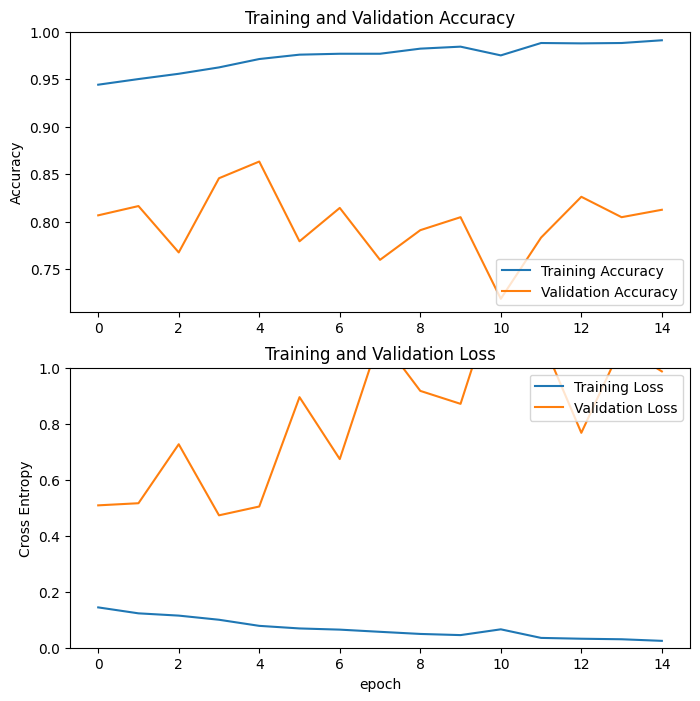

In [26]:
loss_VVST, accuracy_VVST = model_VVST.evaluate(test_dataset)
acc_VVST, val_acc_VVST, loss_VVST, val_loss_VVST = loadHistory('VVSTvgg16XRAY')
distplayHistory(acc_VVST, val_acc_VVST, loss_VVST, val_loss_VVST)

MOBILENET NO TRANSFER

In [17]:
preprocess_input_MNT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MNT= IMG_SIZE + (3,)
mobilenet_model_MNT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MNT,
                                               include_top=False)
image_batch_MNT, label_batch_MNT= next(iter(train_dataset))
feature_batch_MNT= mobilenet_model_MNT(image_batch_MNT)

global_average_layer_MNT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MNT= global_average_layer_MNT(feature_batch_MNT)

fc1_layer_MNT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MNT= fc1_layer_MNT(feature_batch_average_MNT)

prediction_layer_MNT= tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_MNT= prediction_layer_MNT(fc1_batch_MNT)

inputs_MNT= tf.keras.Input(shape=(160, 160, 3))
x_MNT= preprocess_input_MNT(inputs_MNT)
x_MNT= mobilenet_model_MNT(x_MNT)
x_MNT= global_average_layer_MNT(x_MNT)
x_MNT= tf.keras.layers.Dropout(0.2)(x_MNT)
x_MNT= fc1_layer_MNT(x_MNT)
x_MNT= tf.keras.layers.Dropout(0.2)(x_MNT)
outputs_MNT= prediction_layer_MNT(x_MNT)
model_MNT= tf.keras.Model(inputs_MNT, outputs_MNT)
model_MNT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MNT= "training_models/XRAY_MNT.ckpt"
checkpoint_dir_MNT= os.path.dirname(checkpoint_path_MNT)
cp_callback_MNT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MNT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [97]:
total_epochs_MNT = 10
history_MNT = model_MNT.fit(train_dataset,
                         epochs=total_epochs_MNT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MNT])
initial_epochs_MNT=total_epochs_MNT
dumpHistory('MNTmobnetXRAY', history_MNT)

Epoch 1/10
82/82 [==============================] - 64s 706ms/step - loss: 0.2204 - accuracy: 0.9112 - val_loss: 1.6903 - val_accuracy: 0.6094
Epoch 2/10
82/82 [==============================] - 57s 672ms/step - loss: 0.1015 - accuracy: 0.9620 - val_loss: 1.6773 - val_accuracy: 0.6270
Epoch 3/10
82/82 [==============================] - 56s 670ms/step - loss: 0.0687 - accuracy: 0.9758 - val_loss: 1.3711 - val_accuracy: 0.6719
Epoch 4/10
82/82 [==============================] - 57s 670ms/step - loss: 0.0566 - accuracy: 0.9824 - val_loss: 1.1383 - val_accuracy: 0.7031
Epoch 5/10
82/82 [==============================] - 57s 672ms/step - loss: 0.0424 - accuracy: 0.9858 - val_loss: 0.9605 - val_accuracy: 0.7344
Epoch 6/10
82/82 [==============================] - 56s 669ms/step - loss: 0.0377 - accuracy: 0.9877 - val_loss: 0.7905 - val_accuracy: 0.7949
Epoch 7/10
82/82 [==============================] - 56s 669ms/step - loss: 0.0294 - accuracy: 0.9916 - val_loss: 0.7458 - val_accuracy: 0.7988

In [98]:
model_MNT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MNT = 10
total_epochs_MNT =  initial_epochs_MNT + add_epochs_MNT

history_MNT = model_MNT.fit(train_dataset,
                         epochs=total_epochs_MNT,
                         initial_epoch=initial_epochs_MNT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MNT, clr])
initial_epochs_MNT+=add_epochs_MNT
dumpHistory('MNTmobnetXRAY', history_MNT)

Epoch 11/20
82/82 [==============================] - 60s 681ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.7195 - val_accuracy: 0.8145
Epoch 12/20
82/82 [==============================] - 57s 674ms/step - loss: 0.0151 - accuracy: 0.9969 - val_loss: 0.8071 - val_accuracy: 0.8008
Epoch 13/20
82/82 [==============================] - 57s 674ms/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.7277 - val_accuracy: 0.8125
Epoch 14/20
82/82 [==============================] - 57s 674ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.7189 - val_accuracy: 0.8145
Epoch 15/20
82/82 [==============================] - 57s 673ms/step - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.7216 - val_accuracy: 0.8164
Epoch 16/20
82/82 [==============================] - 57s 676ms/step - loss: 0.0122 - accuracy: 0.9975 - val_loss: 0.7020 - val_accuracy: 0.8184
Epoch 17/20
82/82 [==============================] - 57s 674ms/step - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.7256 - val_accuracy:

2/2 [==============================] - 5s 241ms/step - loss: 0.8132 - accuracy: 0.7734


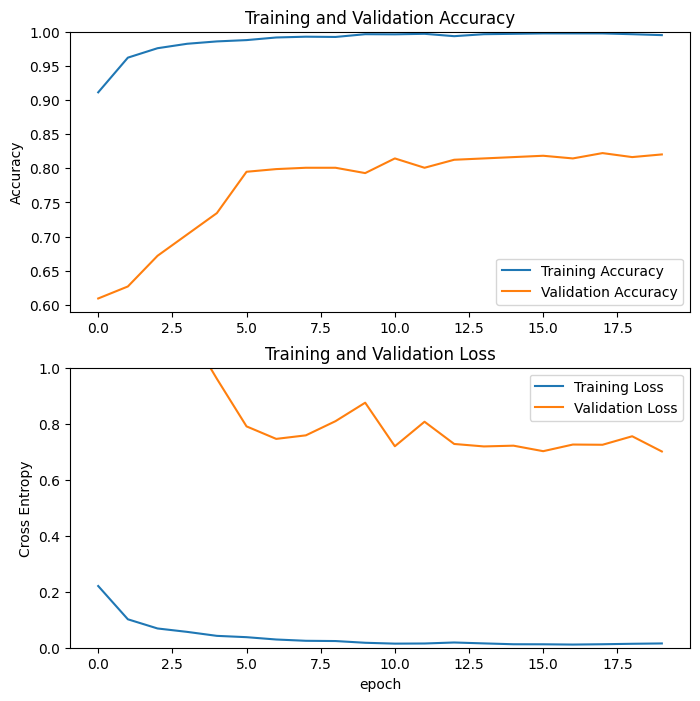

In [18]:
model_MNT.load_weights("training_models/XRAY_MPT.ckpt")
loss_MNT, accuracy_MNT = model_MNT.evaluate(test_dataset)
acc_MNT, val_acc_MNT, loss_MNT, val_loss_MNT = loadHistory('MNTmobnetXRAY')
distplayHistory(acc_MNT, val_acc_MNT, loss_MNT, val_loss_MNT)

MOBILENET FAST TRANSFER

In [27]:
preprocess_input_MFT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MFT= IMG_SIZE + (3,)
mobilenet_model_MFT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MFT,
                                               include_top=False)
mobilenet_model_MFT.trainable = False
image_batch_MFT, label_batch_MFT= next(iter(train_dataset))
feature_batch_MFT= mobilenet_model_MFT(image_batch_MFT)

global_average_layer_MFT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MFT= global_average_layer_MFT(feature_batch_MFT)

fc1_layer_MFT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MFT= fc1_layer_MFT(feature_batch_average_MFT)

prediction_layer_MFT= tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_MFT= prediction_layer_MFT(fc1_batch_MFT)

inputs_MFT= tf.keras.Input(shape=(160, 160, 3))
x_MFT= preprocess_input_MFT(inputs_MFT)
x_MFT= mobilenet_model_MFT(x_MFT)
x_MFT= global_average_layer_MFT(x_MFT)
x_MFT= tf.keras.layers.Dropout(0.2)(x_MFT)
x_MFT= fc1_layer_MFT(x_MFT)
x_MFT= tf.keras.layers.Dropout(0.2)(x_MFT)
outputs_MFT= prediction_layer_MFT(x_MFT)
model_MFT= tf.keras.Model(inputs_MFT, outputs_MFT)
model_MFT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MFT= "training_models/XRAY_MFT.ckpt"
checkpoint_dir_MFT= os.path.dirname(checkpoint_path_MFT)
cp_callback_MFT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MFT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [ ]:
#print("Number of layers in the base model: ", len(mobilenet_model_MFT.layers))

Number of layers in the base model:  86


In [28]:
total_epochs_MFT = 5
history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT])
initial_epochs_MFT=total_epochs_MFT
dumpHistory('MFTmobnetXRAY', history_MFT)

Epoch 1/5
82/82 [==============================] - 26s 262ms/step - loss: 0.3039 - accuracy: 0.8691 - val_loss: 0.2998 - val_accuracy: 0.8848
Epoch 2/5
82/82 [==============================] - 26s 291ms/step - loss: 0.1735 - accuracy: 0.9302 - val_loss: 0.4238 - val_accuracy: 0.8379
Epoch 3/5
82/82 [==============================] - 23s 256ms/step - loss: 0.1481 - accuracy: 0.9448 - val_loss: 0.3984 - val_accuracy: 0.8574
Epoch 4/5
82/82 [==============================] - 22s 253ms/step - loss: 0.1328 - accuracy: 0.9477 - val_loss: 0.5758 - val_accuracy: 0.7891
Epoch 5/5
82/82 [==============================] - 22s 251ms/step - loss: 0.1291 - accuracy: 0.9467 - val_loss: 0.5653 - val_accuracy: 0.8047


In [29]:
mobilenet_model_MFT.trainable = True
fine_tune_at_MFT = 72
for layer_MFT in mobilenet_model_MFT.layers[:fine_tune_at_MFT]:
  layer_MFT.trainable = False
model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MFT = 1
total_epochs_MFT =  initial_epochs_MFT + fine_tune_epochs_MFT

history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=initial_epochs_MFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT])
dumpHistory('MFTmobnetXRAY', history_MFT)
initial_epochs_MFT += fine_tune_epochs_MFT
for i in range (4):
  mobilenet_model_MFT.trainable = True
  fine_tune_at_MFT -= 18
  for layer_MFT in mobilenet_model_MFT.layers[:fine_tune_at_MFT]:
    layer_MFT.trainable = False
  model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MFT = 1
  total_epochs_MFT =  initial_epochs_MFT + fine_tune_epochs_MFT


  history_MFT = model_MFT.fit(train_dataset,
                          epochs=total_epochs_MFT,
                          initial_epoch=initial_epochs_MFT,
                          validation_data=validation_dataset, callbacks=[cp_callback_MFT])
  dumpHistory('MFTmobnetXRAY', history_MFT)
  initial_epochs_MFT+=fine_tune_epochs_MFT


Epoch 6/6
82/82 [==============================] - 27s 286ms/step - loss: 0.2044 - accuracy: 0.9179 - val_loss: 0.4145 - val_accuracy: 0.8359
Epoch 7/7
82/82 [==============================] - 31s 334ms/step - loss: 0.2584 - accuracy: 0.8930 - val_loss: 0.3375 - val_accuracy: 0.8555
Epoch 8/8
82/82 [==============================] - 34s 374ms/step - loss: 0.2313 - accuracy: 0.9095 - val_loss: 0.3265 - val_accuracy: 0.8711
Epoch 9/9
82/82 [==============================] - 43s 474ms/step - loss: 0.2110 - accuracy: 0.9155 - val_loss: 0.3559 - val_accuracy: 0.8574
Epoch 10/10
82/82 [==============================] - 57s 634ms/step - loss: 0.1926 - accuracy: 0.9254 - val_loss: 0.8972 - val_accuracy: 0.7188


In [30]:
model_MFT.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MFT = 10
total_epochs_MFT =  initial_epochs_MFT + add_epochs_MFT

history_MFT = model_MFT.fit(train_dataset,
                         epochs=total_epochs_MFT,
                         initial_epoch=initial_epochs_MFT,
                         validation_data=validation_dataset, callbacks=[cp_callback_MFT, clr])
initial_epochs_MFT+=add_epochs_MFT
dumpHistory('MFTmobnetXRAY', history_MFT)

Epoch 11/20
82/82 [==============================] - 56s 633ms/step - loss: 0.1794 - accuracy: 0.9298 - val_loss: 1.0257 - val_accuracy: 0.7109
Epoch 12/20
82/82 [==============================] - 53s 627ms/step - loss: 0.1623 - accuracy: 0.9383 - val_loss: 0.7432 - val_accuracy: 0.7617
Epoch 13/20
82/82 [==============================] - 53s 625ms/step - loss: 0.1499 - accuracy: 0.9440 - val_loss: 0.4388 - val_accuracy: 0.8457
Epoch 14/20
82/82 [==============================] - 53s 624ms/step - loss: 0.1363 - accuracy: 0.9469 - val_loss: 0.3246 - val_accuracy: 0.8750
Epoch 15/20
82/82 [==============================] - 53s 625ms/step - loss: 0.1228 - accuracy: 0.9542 - val_loss: 0.4284 - val_accuracy: 0.8438
Epoch 16/20
82/82 [==============================] - 53s 624ms/step - loss: 0.1133 - accuracy: 0.9578 - val_loss: 0.4351 - val_accuracy: 0.8477
Epoch 17/20
82/82 [==============================] - 53s 625ms/step - loss: 0.0988 - accuracy: 0.9630 - val_loss: 0.4422 - val_accuracy:

2/2 [==============================] - 2s 200ms/step - loss: 0.4036 - accuracy: 0.8594


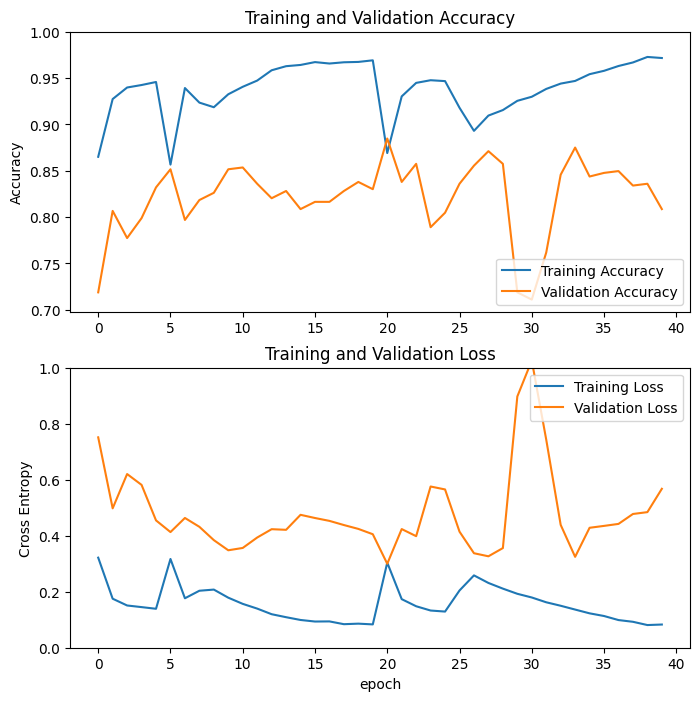

In [31]:
loss_MFT, accuracy_MFT = model_MFT.evaluate(test_dataset)
acc_MFT, val_acc_MFT, loss_MFT, val_loss_MFT = loadHistory('MFTmobnetXRAY')
distplayHistory(acc_MFT, val_acc_MFT, loss_MFT, val_loss_MFT)

MOBILENET SLOW TRANSFER

In [32]:
preprocess_input_MST= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MST= IMG_SIZE + (3,)
mobilenet_model_MST= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MST,
                                               include_top=False)
mobilenet_model_MST.trainable = False
image_batch_MST, label_batch_MST= next(iter(train_dataset))
feature_batch_MST= mobilenet_model_MST(image_batch_MST)

global_average_layer_MST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MST= global_average_layer_MST(feature_batch_MST)

fc1_layer_MST= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MST= fc1_layer_MST(feature_batch_average_MST)

prediction_layer_MST= tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_MST= prediction_layer_MST(fc1_batch_MST)

inputs_MST= tf.keras.Input(shape=(160, 160, 3))
x_MST= preprocess_input_MST(inputs_MST)
x_MST= mobilenet_model_MST(x_MST)
x_MST= global_average_layer_MST(x_MST)
x_MST= tf.keras.layers.Dropout(0.2)(x_MST)
x_MST= fc1_layer_MST(x_MST)
x_MST= tf.keras.layers.Dropout(0.2)(x_MST)
outputs_MST= prediction_layer_MST(x_MST)
model_MST= tf.keras.Model(inputs_MST, outputs_MST)
model_MST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MST= "training_models/XRAY_MST.ckpt"
checkpoint_dir_MST= os.path.dirname(checkpoint_path_MST)
cp_callback_MST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [33]:
total_epochs_MST = 10
history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST])
initial_epochs_MST=total_epochs_MST
dumpHistory('MSTmobnetXRAY', history_MST)

Epoch 1/10
82/82 [==============================] - 25s 263ms/step - loss: 0.3012 - accuracy: 0.8769 - val_loss: 0.4273 - val_accuracy: 0.8262
Epoch 2/10
82/82 [==============================] - 23s 249ms/step - loss: 0.1649 - accuracy: 0.9356 - val_loss: 0.3036 - val_accuracy: 0.8867
Epoch 3/10
82/82 [==============================] - 22s 249ms/step - loss: 0.1479 - accuracy: 0.9431 - val_loss: 0.6574 - val_accuracy: 0.7773
Epoch 4/10
82/82 [==============================] - 22s 249ms/step - loss: 0.1271 - accuracy: 0.9513 - val_loss: 0.4884 - val_accuracy: 0.8242
Epoch 5/10
82/82 [==============================] - 23s 256ms/step - loss: 0.1284 - accuracy: 0.9517 - val_loss: 0.5361 - val_accuracy: 0.8223
Epoch 6/10
82/82 [==============================] - 23s 253ms/step - loss: 0.1273 - accuracy: 0.9528 - val_loss: 0.4940 - val_accuracy: 0.8301
Epoch 7/10
82/82 [==============================] - 22s 251ms/step - loss: 0.1132 - accuracy: 0.9546 - val_loss: 0.5143 - val_accuracy: 0.8262

In [34]:
mobilenet_model_MST.trainable = True
fine_tune_at_MST = 72
for layer_MST in mobilenet_model_MST.layers[:fine_tune_at_MST]:
  layer_MST.trainable = False
model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MST = 2
total_epochs_MST =  initial_epochs_MST + fine_tune_epochs_MST

history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=initial_epochs_MST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST])
dumpHistory('MSTmobnetXRAY', history_MST)
initial_epochs_MST += fine_tune_epochs_MST
for i in range (4):
  mobilenet_model_MST.trainable = True
  fine_tune_at_MST -= 18
  for layer_MST in mobilenet_model_MST.layers[:fine_tune_at_MST]:
    layer_MST.trainable = False
  model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MST = 2
  total_epochs_MST =  initial_epochs_MST + fine_tune_epochs_MST


  history_MST = model_MST.fit(train_dataset,
                          epochs=total_epochs_MST,
                          initial_epoch=initial_epochs_MST,
                          validation_data=validation_dataset, callbacks=[cp_callback_MST])
  dumpHistory('MSTmobnetXRAY', history_MST)
  initial_epochs_MST+=fine_tune_epochs_MST


Epoch 11/12
82/82 [==============================] - 31s 327ms/step - loss: 0.1815 - accuracy: 0.9339 - val_loss: 0.4058 - val_accuracy: 0.8496
Epoch 12/12
82/82 [==============================] - 29s 324ms/step - loss: 0.1570 - accuracy: 0.9398 - val_loss: 0.4151 - val_accuracy: 0.8359
Epoch 13/14
82/82 [==============================] - 34s 358ms/step - loss: 0.2270 - accuracy: 0.9084 - val_loss: 0.3769 - val_accuracy: 0.8574
Epoch 14/14
82/82 [==============================] - 29s 331ms/step - loss: 0.1792 - accuracy: 0.9312 - val_loss: 0.3995 - val_accuracy: 0.8594
Epoch 15/16
82/82 [==============================] - 34s 369ms/step - loss: 0.1862 - accuracy: 0.9306 - val_loss: 0.4053 - val_accuracy: 0.8320
Epoch 16/16
82/82 [==============================] - 31s 365ms/step - loss: 0.1562 - accuracy: 0.9431 - val_loss: 0.4243 - val_accuracy: 0.8223
Epoch 17/18
82/82 [==============================] - 42s 471ms/step - loss: 0.1733 - accuracy: 0.9329 - val_loss: 0.4127 - val_accuracy:

In [35]:
model_MST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MST = 5
total_epochs_MST =  initial_epochs_MST + add_epochs_MST

history_MST = model_MST.fit(train_dataset,
                         epochs=total_epochs_MST,
                         initial_epoch=initial_epochs_MST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MST, clr])
initial_epochs_MST+=add_epochs_MST
dumpHistory('MSTmobnetXRAY', history_MST)

Epoch 21/25
82/82 [==============================] - 55s 633ms/step - loss: 0.1189 - accuracy: 0.9548 - val_loss: 1.1823 - val_accuracy: 0.7070
Epoch 22/25
82/82 [==============================] - 53s 625ms/step - loss: 0.1151 - accuracy: 0.9567 - val_loss: 0.7099 - val_accuracy: 0.7988
Epoch 23/25
82/82 [==============================] - 53s 627ms/step - loss: 0.1098 - accuracy: 0.9599 - val_loss: 0.5246 - val_accuracy: 0.8320
Epoch 24/25
82/82 [==============================] - 53s 626ms/step - loss: 0.1141 - accuracy: 0.9542 - val_loss: 0.4482 - val_accuracy: 0.8535
Epoch 25/25
82/82 [==============================] - 53s 626ms/step - loss: 0.1045 - accuracy: 0.9613 - val_loss: 0.4745 - val_accuracy: 0.8379


2/2 [==============================] - 2s 196ms/step - loss: 0.4115 - accuracy: 0.8516


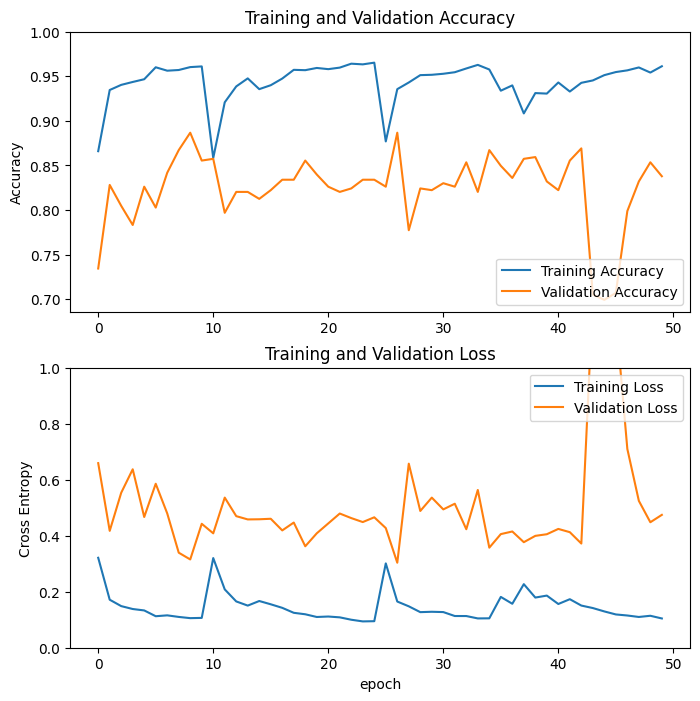

In [36]:
loss_MST, accuracy_MST = model_MST.evaluate(test_dataset)
acc_MST, val_acc_MST, loss_MST, val_loss_MST = loadHistory('MSTmobnetXRAY')
distplayHistory(acc_MST, val_acc_MST, loss_MST, val_loss_MST)

MOBILE NET PARTICAL TRANSFER

In [21]:
preprocess_input_MPT= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MPT= IMG_SIZE + (3,)
mobilenet_model_MPT= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MPT,
                                               include_top=False)
mobilenet_model_MPT.trainable = False
image_batch_MPT, label_batch_MPT= next(iter(train_dataset))
feature_batch_MPT= mobilenet_model_MPT(image_batch_MPT)

global_average_layer_MPT= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MPT= global_average_layer_MPT(feature_batch_MPT)

fc1_layer_MPT= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MPT= fc1_layer_MPT(feature_batch_average_MPT)

prediction_layer_MPT= tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_MPT= prediction_layer_MPT(fc1_batch_MPT)

inputs_MPT= tf.keras.Input(shape=(160, 160, 3))
x_MPT= preprocess_input_MPT(inputs_MPT)
x_MPT= mobilenet_model_MPT(x_MPT)
x_MPT= global_average_layer_MPT(x_MPT)
x_MPT= tf.keras.layers.Dropout(0.2)(x_MPT)
x_MPT= fc1_layer_MPT(x_MPT)
x_MPT= tf.keras.layers.Dropout(0.2)(x_MPT)
outputs_MPT= prediction_layer_MPT(x_MPT)
model_MPT= tf.keras.Model(inputs_MPT, outputs_MPT)
model_MPT.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MPT= "training_models/XRAY_MPT.ckpt"
checkpoint_dir_MPT= os.path.dirname(checkpoint_path_MPT)
cp_callback_MPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MPT,
                                                 save_weights_only=True,
                                                 verbose=0)


In [20]:
total_epochs_MPT = 20
history_MPT = model_MPT.fit(train_dataset,
                         epochs=total_epochs_MPT,
                         initial_epoch=0,
                         validation_data=validation_dataset, callbacks=[cp_callback_MPT])
initial_epochs_MPT=total_epochs_MPT
dumpHistory('MPTmobnetXRAY', history_MPT)

Epoch 1/20
 5/82 [>.............................] - ETA: 23s - loss: 0.7685 - accuracy: 0.6938

KeyboardInterrupt: 

In [22]:
model_MPT.load_weights("training_models/XRAY_MPT.ckpt")
checkpoint_path_MPT= "training_models/XRAY_MFPT.ckpt"
checkpoint_dir_MPT= os.path.dirname(checkpoint_path_MPT)
cp_callback_MPT= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MPT,
                                                 save_weights_only=True,
                                                 verbose=0)
total_epochs_MPT = 40
history_MPT = model_MPT.fit(train_dataset,
                         epochs=total_epochs_MPT,
                         initial_epoch=20,
                         validation_data=validation_dataset, callbacks=[cp_callback_MPT, clr])
initial_epochs_MPT=total_epochs_MPT
dumpHistory('MPTmobnetXRAY', history_MPT)

Epoch 21/40
82/82 [==============================] - 33s 354ms/step - loss: 0.0999 - accuracy: 0.9624 - val_loss: 0.6441 - val_accuracy: 0.7969
Epoch 22/40
82/82 [==============================] - 26s 295ms/step - loss: 0.0859 - accuracy: 0.9686 - val_loss: 0.5638 - val_accuracy: 0.8301
Epoch 23/40
82/82 [==============================] - 26s 296ms/step - loss: 0.0867 - accuracy: 0.9668 - val_loss: 0.4848 - val_accuracy: 0.8457
Epoch 24/40
82/82 [==============================] - 26s 294ms/step - loss: 0.0835 - accuracy: 0.9716 - val_loss: 0.5219 - val_accuracy: 0.8340
Epoch 25/40
82/82 [==============================] - 25s 280ms/step - loss: 0.0811 - accuracy: 0.9674 - val_loss: 0.5368 - val_accuracy: 0.8320
Epoch 26/40
82/82 [==============================] - 25s 282ms/step - loss: 0.0841 - accuracy: 0.9682 - val_loss: 0.5382 - val_accuracy: 0.8320
Epoch 27/40
82/82 [==============================] - 25s 280ms/step - loss: 0.0868 - accuracy: 0.9680 - val_loss: 0.5038 - val_accuracy:

2/2 [==============================] - 2s 232ms/step - loss: 0.3787 - accuracy: 0.8594


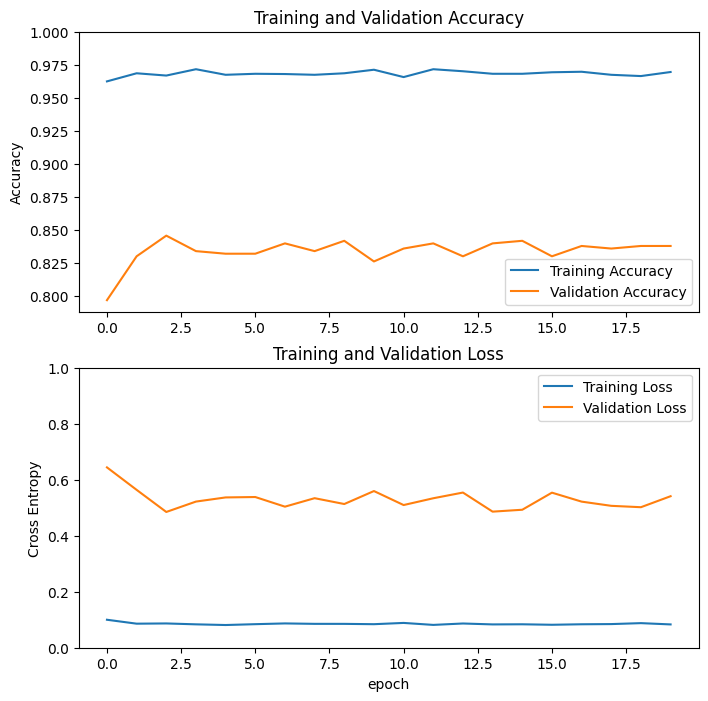

In [23]:
loss_MPT, accuracy_MPT = model_MPT.evaluate(test_dataset)
acc_MPT, val_acc_MPT, loss_MPT, val_loss_MPT = loadHistory('MPTmobnetXRAY')
distplayHistory(acc_MPT, val_acc_MPT, loss_MPT, val_loss_MPT)

MOBILE NET VERY SLOW TRANSFER

In [41]:
preprocess_input_MVST= tf.keras.applications.mobilenet.preprocess_input
IMG_SHAPE_MVST= IMG_SIZE + (3,)
mobilenet_model_MVST= tf.keras.applications.MobileNet(input_shape=IMG_SHAPE_MVST,
                                               include_top=False)
mobilenet_model_MVST.trainable = False
image_batch_MVST, label_batch_MVST= next(iter(train_dataset))
feature_batch_MVST= mobilenet_model_MVST(image_batch_MVST)

global_average_layer_MVST= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_MVST= global_average_layer_MVST(feature_batch_MVST)

fc1_layer_MVST= tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
fc1_batch_MVST= fc1_layer_MVST(feature_batch_average_MVST)

prediction_layer_MVST= tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
prediction_batch_MVST= prediction_layer_MVST(fc1_batch_MVST)

inputs_MVST= tf.keras.Input(shape=(160, 160, 3))
x_MVST= preprocess_input_MVST(inputs_MVST)
x_MVST= mobilenet_model_MVST(x_MVST)
x_MVST= global_average_layer_MVST(x_MVST)
x_MVST= tf.keras.layers.Dropout(0.2)(x_MVST)
x_MVST= fc1_layer_MVST(x_MVST)
x_MVST= tf.keras.layers.Dropout(0.2)(x_MVST)
outputs_MVST= prediction_layer_MVST(x_MVST)
model_MVST= tf.keras.Model(inputs_MVST, outputs_MVST)
model_MVST.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path_MVST= "training_models/XRAY_MVST.ckpt"
checkpoint_dir_MVST= os.path.dirname(checkpoint_path_MVST)
cp_callback_MVST= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_MVST,
                                                 save_weights_only=True,
                                                 verbose=0)


In [46]:
model_MVST.load_weights("training_models/XRAY_MPT.ckpt")
mobilenet_model_MVST.trainable = True
initial_epochs_MVST=20
fine_tune_at_MVST = 72
for layer_MVST in mobilenet_model_MVST.layers[:fine_tune_at_MVST]:
  layer_MVST.trainable = False
model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs_MVST = 1
total_epochs_MVST =  initial_epochs_MVST + fine_tune_epochs_MVST

history_MVST = model_MVST.fit(train_dataset,
                         epochs=total_epochs_MVST,
                         initial_epoch=initial_epochs_MVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MVST])
dumpHistory('MVSTmobnetXRAY', history_MVST)
initial_epochs_MVST += fine_tune_epochs_MVST
for i in range (9):
  mobilenet_model_MVST.trainable = True
  fine_tune_at_MVST -= 8
  for layer_MVST in mobilenet_model_MVST.layers[:fine_tune_at_MVST]:
    layer_MVST.trainable = False
  model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
                metrics=['accuracy'])
  fine_tune_epochs_MVST = 1
  total_epochs_MVST =  initial_epochs_MVST + fine_tune_epochs_MVST


  history_MVST = model_MVST.fit(train_dataset,
                          epochs=total_epochs_MVST,
                          initial_epoch=initial_epochs_MVST,
                          validation_data=validation_dataset, callbacks=[cp_callback_MVST])
  dumpHistory('MVSTmobnetXRAY', history_MVST)
  initial_epochs_MVST+=fine_tune_epochs_MVST


Epoch 21/21
82/82 [==============================] - 27s 279ms/step - loss: 0.1677 - accuracy: 0.9390 - val_loss: 0.3910 - val_accuracy: 0.8496
Epoch 22/22
82/82 [==============================] - 28s 304ms/step - loss: 0.1758 - accuracy: 0.9350 - val_loss: 0.4108 - val_accuracy: 0.8340
Epoch 23/23
82/82 [==============================] - 30s 325ms/step - loss: 0.2076 - accuracy: 0.9153 - val_loss: 0.4084 - val_accuracy: 0.8242
Epoch 24/24
82/82 [==============================] - 31s 341ms/step - loss: 0.1850 - accuracy: 0.9279 - val_loss: 0.3812 - val_accuracy: 0.8594
Epoch 25/25
82/82 [==============================] - 33s 365ms/step - loss: 0.1907 - accuracy: 0.9222 - val_loss: 0.3087 - val_accuracy: 0.8750
Epoch 26/26
82/82 [==============================] - 35s 388ms/step - loss: 0.1678 - accuracy: 0.9375 - val_loss: 0.4855 - val_accuracy: 0.8223
Epoch 27/27
82/82 [==============================] - 39s 426ms/step - loss: 0.1527 - accuracy: 0.9387 - val_loss: 0.3756 - val_accuracy:

In [47]:
model_MVST.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=min_LR),
              metrics=['accuracy'])
add_epochs_MVST = 5
total_epochs_MVST =  initial_epochs_MVST + add_epochs_MVST

history_MVST = model_MVST.fit(train_dataset,
                         epochs=total_epochs_MVST,
                         initial_epoch=initial_epochs_MVST,
                         validation_data=validation_dataset, callbacks=[cp_callback_MVST, clr])
initial_epochs_MVST+=add_epochs_MVST
dumpHistory('MVSTmobnetXRAY', history_MVST)

Epoch 31/35
82/82 [==============================] - 57s 645ms/step - loss: 0.1202 - accuracy: 0.9559 - val_loss: 1.1776 - val_accuracy: 0.7227
Epoch 32/35
82/82 [==============================] - 54s 629ms/step - loss: 0.1114 - accuracy: 0.9613 - val_loss: 1.0587 - val_accuracy: 0.7363
Epoch 33/35
82/82 [==============================] - 54s 634ms/step - loss: 0.1069 - accuracy: 0.9620 - val_loss: 0.6602 - val_accuracy: 0.8125
Epoch 34/35
82/82 [==============================] - 53s 630ms/step - loss: 0.1167 - accuracy: 0.9546 - val_loss: 0.4972 - val_accuracy: 0.8457
Epoch 35/35
82/82 [==============================] - 56s 670ms/step - loss: 0.1095 - accuracy: 0.9582 - val_loss: 0.4952 - val_accuracy: 0.8418


2/2 [==============================] - 3s 223ms/step - loss: 0.6111 - accuracy: 0.8281


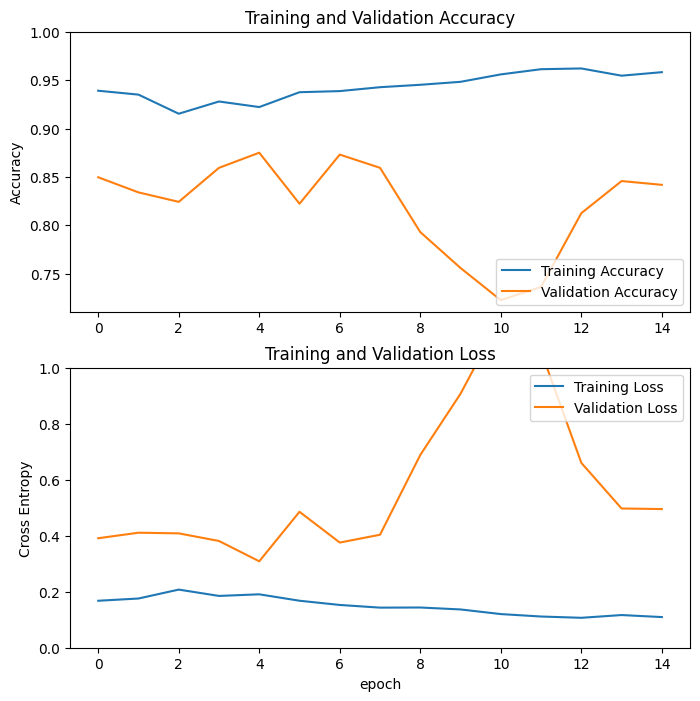

In [48]:
loss_MVST, accuracy_MVST = model_MVST.evaluate(test_dataset)
acc_MVST, val_acc_MVST, loss_MVST, val_loss_MVST = loadHistory('MVSTmobnetXRAY')
distplayHistory(acc_MVST, val_acc_MVST, loss_MVST, val_loss_MVST)